In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 

%matplotlib inline



#ランダムシードの設定
import random
np.random.seed(2021)
random.seed(2021)

In [2]:
input = Path('input')
df = pd.read_csv(input / 'join_data.csv')
sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']
print(df.shape)
df.head()

(8092, 14)


,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
#欠損値を平均で補完

df.replace('None',np.nan,inplace=True)

for col in ['acousticness','positiveness','danceability',
        'liveness','speechiness','instrumentalness']:
    df[col] = df[col].astype('float64')
    df_mean = df[col].mean()
    df[col].fillna(df_mean,inplace=True)
    
df.isnull().sum()

index               0
genre               0
popularity          0
duration_ms         0
acousticness        0
positiveness        0
danceability        0
loudness            0
energy              1
liveness            0
speechiness         0
instrumentalness    0
tempo               0
region              0
dtype: int64

In [11]:
#標準化

df['log_tempo'] = np.log(df['tempo'])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'music_nature_sum',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]
    
df.head()

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,standardscaled_log_tempo,standardscaled_music_nature_sum
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,0.544048,0.911856
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,1.248860,-0.555563
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,-1.978618,-0.426804
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,1.682276,-0.418702
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,-0.323149,1.078265


In [12]:
df['music_nature'] = 0
for col in [
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    df['music_nature'] += df[col]
df['music_nature'].head()

0    5.742936
1   -0.863710
2   -0.393039
3    0.068024
4    3.675958
Name: music_nature, dtype: float64

In [14]:
df['nature_factor'] = 0
df['exciting_factor'] = 0
df['language_factor'] = 0
df['fine_factor'] = 0
df['nofeature_factor'] = 0
df['song_factor'] = 0

for col in [
    'standardscaled_acousticness','standardscaled_loudness','standardscaled_energy'
]:
    df['nature_factor'] += df[col]

for col in [
    'standardscaled_positiveness','standardscaled_danceability','standardscaled_instrumentalness'
]:
    df['exciting_factor'] += df[col]

for col in [
    'standardscaled_liveness','standardscaled_speechiness'
]:
    df['language_factor'] += df[col]

for col in [
    'standardscaled_positiveness','standardscaled_danceability'
]:
    df['fine_factor'] += df[col]
    
for col in [
    'standardscaled_liveness','standardscaled_speechiness','standardscaled_instrumentalness'
]:
    df['nofeature_factor'] = df[col]
    
for col in [
    'standardscaled_loudness','standardscaled_instrumentalness'
]:
    df['song_factor'] += df[col]
    
df[['nature_factor','exciting_factor','language_factor','fine_factor','nofeature_factor','song_factor']].head()

,nature_factor,exciting_factor,language_factor,fine_factor,nofeature_factor,song_factor
0,1.907340,0.985881,2.849715,-3.352774,4.338655,5.768700
1,0.857923,-0.795320,-0.926314,-0.206800,-0.588519,-0.062652
2,-0.566170,-1.492048,1.665179,-1.177654,-0.314395,-0.704443
3,1.212081,-2.156487,1.012429,-1.899606,-0.256881,0.382009
4,0.513928,3.527748,-0.365718,3.458514,0.069233,0.993303


In [15]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo',
    'pca_0','pca_1','pca_2','factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor','fine_factor','nofeature_factor','song_factor'
    ]

data = df[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,fine_factor,nofeature_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,-3.352774,4.338655,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.206800,-0.588519,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-1.177654,-0.314395,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,-1.899606,-0.256881,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,3.458514,0.069233,0.993303


In [17]:
train = pd.read_csv(input / 'train.csv')
test = pd.read_csv(input / 'test.csv')
train_len = len(train)
print(train_len)

4046


In [8]:
train_X = data[:train_len]
train_y = df['genre'][:train_len]
test_X = data[train_len:]

NameError: name 'data' is not defined

In [48]:
train_X.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_log_tempo,pca_0,pca_1,pca_2,music_nature,nature_factor,exciting_factor,language_factor,fine_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,0.544048,-0.261937,5.044936,2.521302,5.742936,1.907340,0.985881,2.849715,-3.352774,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,1.248860,-1.661705,0.255611,-1.272544,-0.863710,0.857923,-0.795320,-0.926314,-0.206800,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,-1.978618,1.268983,0.030598,0.715309,-0.393039,-0.566170,-1.492048,1.665179,-1.177654,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,1.682276,-1.407780,1.502747,-0.809620,0.068024,1.212081,-2.156487,1.012429,-1.899606,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,-0.323149,-1.798215,-1.600899,0.474826,3.675958,0.513928,3.527748,-0.365718,3.458514,0.993303


In [37]:
test_X.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_log_tempo,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,fine_factor,song_factor
4046,0,0,0,0,0,0,0,0,1,0,...,-1.179132,0.045675,-0.308863,1.227782,1.053333,-0.132652,0.229831,0.956154,0.573507,-1.464994
4047,0,0,0,0,0,0,0,0,0,0,...,0.544048,-1.239764,0.027570,-0.451365,0.661655,1.613051,-0.095112,-0.856285,0.290199,0.864969
4048,0,0,0,0,0,0,0,0,0,0,...,0.544048,-1.153531,-0.270230,-0.205555,2.752412,1.343271,0.760414,0.648727,0.992876,0.813645
4049,0,0,0,1,0,0,0,0,0,0,...,-1.179132,0.381477,0.196475,0.492344,-3.293019,-1.449015,-0.800474,-1.043529,-0.612266,-0.967114
4050,0,0,0,0,1,0,0,0,0,0,...,-0.323149,-0.004423,-0.544470,0.359166,0.526355,-0.273861,0.971005,-0.170789,1.171574,-0.552014


In [13]:
train_y.head()

0    10
1     8
2     3
3    10
4     3
Name: genre, dtype: int64

In [21]:
from sklearn.metrics import f1_score

def LogisticModel(train_X,train_y):
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    model = LogisticRegression(multi_class="multinomial",solver ="newton-cg")
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    F1 = f1_score(y_valid,np.round(y_pred),average="macro")
    
    print('正解率(train): {:.3f}'.format(model.score(X_train,y_train)))
    print('正解率(test): {:.3f}'.format(model.score(X_valid,y_valid)))
    print('正解率(F1): {:.3f}'.format(F1))

In [79]:
LogisticModel(train_X,train_y)  #clusterlabel有

正解率(train): 0.604
正解率(test): 0.581
正解率(F1): 0.528


In [61]:
sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

model = LogisticRegression(multi_class="multinomial",solver ="newton-cg")
def Predict(train_X,train_y,test_X,model):
    model.fit(train_X, train_y)
    test['prediction'] = model.predict(test_X)
    submission_df = sample_sub.copy()
    submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
    assert not submission_df["genre"].isna().any()
    #submission_df.head(10)
    
    return submission_df

In [81]:
LogisticSubmission = LogisticPredict(train_X,train_y,test_X)

In [83]:
LogisticSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,8
9,4055,10


In [84]:
output = Path('output')
LogisticSubmission.to_csv(output / "LogisticSubmission.csv", header=None, index=False)

In [280]:
#サポートベクトマシン

from sklearn import svm

def SVCModel(train_X,train_y):
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    models = {
        'nomal': svm.SVC(),
        'liner': svm.LinearSVC(),
        'kernel_liner': svm.SVC(kernel='linear'),
        'kernel_rbf': svm.SVC(kernel='rbf'),
        'kernel_sigmoid': svm.SVC(kernel='sigmoid')
    }

    f1scores = {}
    for model_name, model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_valid)
        f1scores[(model_name,'f1score')] = f1_score(y_valid,np.round(y_pred),average="macro")
    
    return pd.Series(f1scores).unstack()

In [102]:
SVCModel(train_X,train_y)  #clusterlabel有

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,f1score
kernel_liner,0.472839
kernel_rbf,0.367784
kernel_sigmoid,0.188724
liner,0.447584
nomal,0.367784


In [4]:
#knn

from sklearn.neighbors import KNeighborsClassifier

def KnnModel(train_X,train_y):
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    f1score = []
    for n_neighbors in range(1,21):
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_valid)
        F1 = f1_score(y_valid,np.round(y_pred),average="macro")
        f1score.append(F1)
    
    plt.plot(range(1,21),f1score)
    plt.xlabel('n_neighbors')
    plt.ylabel('f1score')

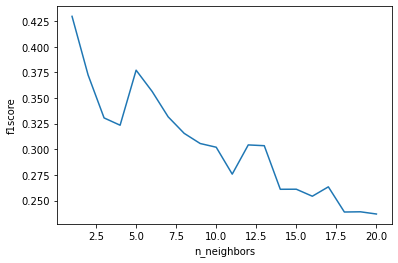

In [106]:
KnnModel(train_X,train_y)  #clusterlabel有

In [57]:
from sklearn.tree import DecisionTreeClassifier

def tree(train_X,train_y):
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    models = {
        'tree1': DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=2021),
        'tree2': DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2021),
        'tree3': DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=2021),
        'tree4': DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=2021),
        'tree5': DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=2021),
        'tree6': DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=2021),
        'tree7':DecisionTreeClassifier(criterion='entropy',max_depth=20,random_state=2021),
        'tree8':DecisionTreeClassifier(criterion='entropy',max_depth=15,random_state=2021),
        'tree9':DecisionTreeClassifier(criterion='entropy',max_depth=30,random_state=2021),
        'tree10':DecisionTreeClassifier(criterion='entropy',max_depth=18,random_state=2021),
        'tree11':DecisionTreeClassifier(criterion='entropy',max_depth=22,random_state=2021),
        'tree12':DecisionTreeClassifier(criterion='entropy',max_depth=25,random_state=2021),
    }

    f1scores = {}
    for model_name, model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_valid)
        f1scores[(model_name,'f1score')] = f1_score(y_valid,np.round(y_pred),average="macro")
    
    return pd.Series(f1scores).unstack()

In [118]:
tree(train_X,train_y)  #深さ22らへんがベスト? 後でgodresearh ,   clusterlabel有

,f1score
tree1,0.195429
tree10,0.451715
tree11,0.474716
tree12,0.460478
tree2,0.312150
tree3,0.454260
tree4,0.152356
tree5,0.190109
tree6,0.408505
tree7,0.468617


In [21]:
import lightgbm as lgb

def LightGBM(train_X,train_y):
    
    
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)
    
    lgbm_params = {
        'task':'train',
        'objective': 'multiclass', # 目的 : 多クラス分類 
        'num_class': 11, # クラス数 : 11
        "learning_rate": 0.01,
        'num_leaves':31,
        "n_estimators": 10000,
        'random_state':2021
}
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         early_stopping_rounds=100)

    
    return model_lgb

In [94]:
lgb_features = [
    'region',
   'popularity', 'duration_ms',
   'acousticness', 'positiveness',
   'danceability', 'loudness',
   'energy', 'liveness',
   'speechiness', 'instrumentalness',
   'tempo', 'music_nature_sum',
    'pca_0','pca_1','pca_2',
    'pca_cluster'
    ]

lgb_data = df[lgb_features]
lgb_data.head()

,region,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,music_nature_sum,pca_0,pca_1,pca_2,pca_cluster
0,region_H,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,136.5,2.994378,-0.261937,5.044936,2.521302,5
1,region_I,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,164.5,2.356047,-1.661705,0.255611,-1.272544,0
2,region_E,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,70.0,2.412058,1.268983,0.030598,0.715309,4
3,region_C,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,184.5,2.415582,-1.407780,1.502747,-0.809620,0
4,unknown,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,108.5,3.066767,-1.798215,-1.600899,0.474826,1


In [13]:
lgb_train_X = lgb_data[:train_len]
lgb_train_y = df['genre'][:train_len]
lgb_test_X = lgb_data[train_len:]

In [15]:
categories = ['region','pca_cluster']

In [67]:
lightgbm = LightGBM(lgb_train_X,lgb_train_y)

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Unknown parameter: andom_seed
[LightGBM] [Warning] Unknown parameter: andom_seed
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3434
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 17
[LightGBM] [Warning] Unknown parameter: andom_seed
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info

In [27]:
lgb_train_X['region'] = train['region'].astype('category').values.codes
lgb_train_X.head()

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,region,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,music_nature_sum,pca_0,pca_1,pca_2,pca_cluster
0,7,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,136.5,2.994378,-0.261937,5.044936,2.521302,5
1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,164.5,2.356047,-1.661705,0.255611,-1.272544,0
2,4,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,70.0,2.412058,1.268983,0.030598,0.715309,4
3,2,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,184.5,2.415582,-1.407780,1.502747,-0.809620,0
4,20,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,108.5,3.066767,-1.798215,-1.600899,0.474826,1


In [69]:
importance = lightgbm.feature_importance()

In [102]:
def LightGBMimportance(model,X_train):
    importance = pd.DataFrame(model,index=X_train.columns,columns=['importance']).sort_values(by='importance',ascending=True)
    importance.plot.barh()

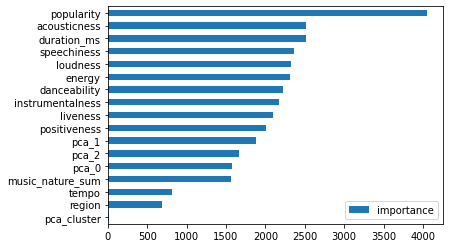

In [71]:
LightGBMimportance(importance,lgb_train_X)

In [54]:
LogisticModel(train_X,train_y)  #clasterlabel無

正解率(train): 0.601
正解率(test): 0.586
正解率(F1): 0.511


In [56]:
SVCModel(train_X,train_y)  #clusterlabel無

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,f1score
kernel_liner,0.453985
kernel_rbf,0.385800
kernel_sigmoid,0.193982
liner,0.446105
nomal,0.385800


In [58]:
tree(train_X,train_y) #clusterlabel無

,f1score
tree1,0.195429
tree10,0.472398
tree11,0.469099
tree12,0.471840
tree2,0.303594
tree3,0.426349
tree4,0.152356
tree5,0.190109
tree6,0.391608
tree7,0.480758


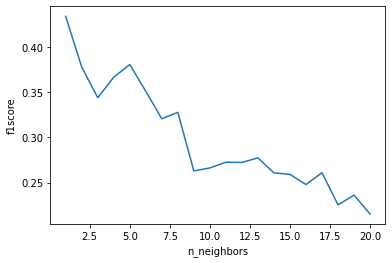

In [60]:
KnnModel(train_X,train_y) #clusterlabel無

In [62]:
model = KNeighborsClassifier(n_neighbors=1)

KnnSubmission = Predict(train_X,train_y,test_X,model)

KnnSubmission.head(20)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,2
6,4052,10
7,4053,4
8,4054,3
9,4055,10


In [63]:
output = Path('output')
KnnSubmission.to_csv(output / "KnnSubmission.csv", header=None, index=False)

In [64]:
model = DecisionTreeClassifier(criterion='entropy',max_depth=20,random_state=2021)

TreeSubmission = Predict(train_X,train_y,test_X,model)

TreeSubmission.head(20)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,1
6,4052,9
7,4053,4
8,4054,3
9,4055,10


In [65]:
output = Path('output')
TreeSubmission.to_csv(output / "TreeSubmission.csv", header=None, index=False)

In [25]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3445
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 34
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[188]	valid_0's multi_logloss: 1.03057
[189]	valid_0's multi_logloss: 1.02992
[190]	valid_0's multi_logloss: 1.02961
[191]	valid_0's multi_logloss: 1.02904
[192]	valid_0's multi_logloss: 1.02865
[193]	valid_0's multi_logloss: 1.02792
[194]	valid_0's multi_logloss: 1.02739
[195]	valid_0's multi_logloss: 1.02676
[196]	valid_0's multi_logloss: 1.02609
[197]	valid_0's multi_logloss: 1.02557
[198]	valid_0's multi_logloss: 1.02511
[199]	valid_0's multi_logloss: 1.02453
[200]	valid_0's multi_logloss: 1.02423
[201]	valid_0's multi_logloss: 1.02373
[202]	valid_0's multi_logloss: 1.02345
[203]	valid_0's multi_logloss: 1.02327
[204]	valid_0's multi_logloss: 1.02254
[205]	valid_0's multi_logloss: 1.02223
[206]	valid_0's multi_logloss: 1.02208
[207]	valid_0's multi_logloss: 1.0216
[208]	valid_0's multi_logloss: 1.02106
[209]	valid_0's multi_logloss: 1.02051
[210]	valid_0's multi_logloss: 1.02032
[211]	valid_0's multi_logloss: 1.01973
[212]	valid_0's multi_logloss: 1.01926
[213]	valid_0's multi_logl

[403]	valid_0's multi_logloss: 1.00683
[404]	valid_0's multi_logloss: 1.00676
[405]	valid_0's multi_logloss: 1.00684
[406]	valid_0's multi_logloss: 1.00697
[407]	valid_0's multi_logloss: 1.0068
[408]	valid_0's multi_logloss: 1.00706
[409]	valid_0's multi_logloss: 1.00696
[410]	valid_0's multi_logloss: 1.00708
[411]	valid_0's multi_logloss: 1.00724
[412]	valid_0's multi_logloss: 1.00737
[413]	valid_0's multi_logloss: 1.00778
[414]	valid_0's multi_logloss: 1.00787
[415]	valid_0's multi_logloss: 1.00819
[416]	valid_0's multi_logloss: 1.0082
[417]	valid_0's multi_logloss: 1.00818
[418]	valid_0's multi_logloss: 1.00828
[419]	valid_0's multi_logloss: 1.00859
[420]	valid_0's multi_logloss: 1.00843
[421]	valid_0's multi_logloss: 1.00858
[422]	valid_0's multi_logloss: 1.00859
[423]	valid_0's multi_logloss: 1.00881
[424]	valid_0's multi_logloss: 1.0089
[425]	valid_0's multi_logloss: 1.00903
[426]	valid_0's multi_logloss: 1.00898
[427]	valid_0's multi_logloss: 1.00896
[428]	valid_0's multi_loglos

In [27]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,8
9,4055,10


In [28]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission.csv", header=None, index=False)

In [30]:
importance = model_lgb.feature_importance()

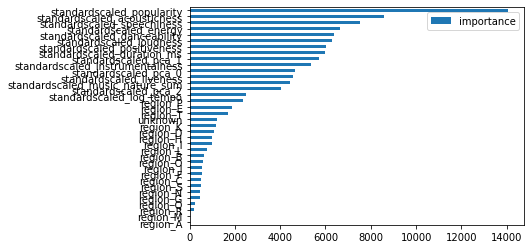

In [35]:
LightGBMimportance(importance,train_X)

In [36]:
features = [
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
    'standardscaled_music_nature_sum',
    'standardscaled_pca_0','standardscaled_pca_1','standardscaled_pca_2',
    ]

NoRegionTempodata = df[features]
NoRegionTempodata.head()

,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,standardscaled_music_nature_sum,standardscaled_pca_0,standardscaled_pca_1,standardscaled_pca_2
0,-1.866000,-0.499932,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,0.911856,-0.158863,3.953130,2.348438
1,1.728761,0.812810,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,-0.555563,-1.007812,0.200293,-1.185297
2,0.117317,-0.547223,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,-0.426804,0.769629,0.023976,0.666266
3,0.241274,0.722347,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,-0.418702,-0.853808,1.177528,-0.754111
4,0.985018,0.432123,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,1.078265,-1.090604,-1.254439,0.442271


In [39]:
train_X = NoRegionTempodata[:train_len]
train_y = df['genre'][:train_len]
test_X = NoRegionTempodata[train_len:]

In [40]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 14
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[192]	valid_0's multi_logloss: 1.30544
[193]	valid_0's multi_logloss: 1.30522
[194]	valid_0's multi_logloss: 1.3051
[195]	valid_0's multi_logloss: 1.30527
[196]	valid_0's multi_logloss: 1.30535
[197]	valid_0's multi_logloss: 1.3053
[198]	valid_0's multi_logloss: 1.30529
[199]	valid_0's multi_logloss: 1.30535
[200]	valid_0's multi_logloss: 1.30528
[201]	valid_0's multi_logloss: 1.30536
[202]	valid_0's multi_logloss: 1.30546
[203]	valid_0's multi_logloss: 1.30537
[204]	valid_0's multi_logloss: 1.30546
[205]	valid_0's multi_logloss: 1.30531
[206]	valid_0's multi_logloss: 1.30548
[207]	valid_0's multi_logloss: 1.30535
[208]	valid_0's multi_logloss: 1.30544
[209]	valid_0's multi_logloss: 1.30504
[210]	valid_0's multi_logloss: 1.30509
[211]	valid_0's multi_logloss: 1.30494
[212]	valid_0's multi_logloss: 1.30479
[213]	valid_0's multi_logloss: 1.30482
[214]	valid_0's multi_logloss: 1.30471
[215]	valid_0's multi_logloss: 1.30484
[216]	valid_0's multi_logloss: 1.30479
[217]	valid_0's multi_loglo

In [41]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,8
4,4050,8
5,4051,8
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [42]:
output = Path('output')
LightGBMSubmission.to_csv(output / "Remove(Region&Tempo)LightGBMSubmission.csv", header=None, index=False)

In [43]:
importance = model_lgb.feature_importance()

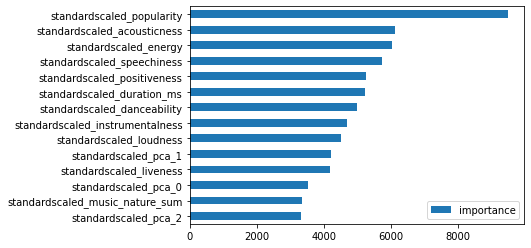

In [44]:
LightGBMimportance(importance,train_X)

In [22]:
model_lgb = LightGBM(train_X,train_y)

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5740
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 43
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[190]	valid_0's multi_logloss: 1.03425
[191]	valid_0's multi_logloss: 1.03372
[192]	valid_0's multi_logloss: 1.03321
[193]	valid_0's multi_logloss: 1.03252
[194]	valid_0's multi_logloss: 1.03204
[195]	valid_0's multi_logloss: 1.03131
[196]	valid_0's multi_logloss: 1.03074
[197]	valid_0's multi_logloss: 1.03013
[198]	valid_0's multi_logloss: 1.02957
[199]	valid_0's multi_logloss: 1.02901
[200]	valid_0's multi_logloss: 1.02844
[201]	valid_0's multi_logloss: 1.02809
[202]	valid_0's multi_logloss: 1.02739
[203]	valid_0's multi_logloss: 1.02686
[204]	valid_0's multi_logloss: 1.02647
[205]	valid_0's multi_logloss: 1.02598
[206]	valid_0's multi_logloss: 1.02534
[207]	valid_0's multi_logloss: 1.02491
[208]	valid_0's multi_logloss: 1.02451
[209]	valid_0's multi_logloss: 1.02421
[210]	valid_0's multi_logloss: 1.02384
[211]	valid_0's multi_logloss: 1.02362
[212]	valid_0's multi_logloss: 1.0231
[213]	valid_0's multi_logloss: 1.02297
[214]	valid_0's multi_logloss: 1.02256
[215]	valid_0's multi_logl

[403]	valid_0's multi_logloss: 1.00483
[404]	valid_0's multi_logloss: 1.00514
[405]	valid_0's multi_logloss: 1.00493
[406]	valid_0's multi_logloss: 1.00477
[407]	valid_0's multi_logloss: 1.00479
[408]	valid_0's multi_logloss: 1.00494
[409]	valid_0's multi_logloss: 1.00499
[410]	valid_0's multi_logloss: 1.00478
[411]	valid_0's multi_logloss: 1.00478
[412]	valid_0's multi_logloss: 1.00466
[413]	valid_0's multi_logloss: 1.00458
[414]	valid_0's multi_logloss: 1.00447
[415]	valid_0's multi_logloss: 1.00473
[416]	valid_0's multi_logloss: 1.00494
[417]	valid_0's multi_logloss: 1.00502
[418]	valid_0's multi_logloss: 1.00499
[419]	valid_0's multi_logloss: 1.00521
[420]	valid_0's multi_logloss: 1.00506
[421]	valid_0's multi_logloss: 1.00523
[422]	valid_0's multi_logloss: 1.00505
[423]	valid_0's multi_logloss: 1.00519
[424]	valid_0's multi_logloss: 1.00519
[425]	valid_0's multi_logloss: 1.00551
[426]	valid_0's multi_logloss: 1.00563
[427]	valid_0's multi_logloss: 1.00568
[428]	valid_0's multi_log

In [23]:
importance = model_lgb.feature_importance()

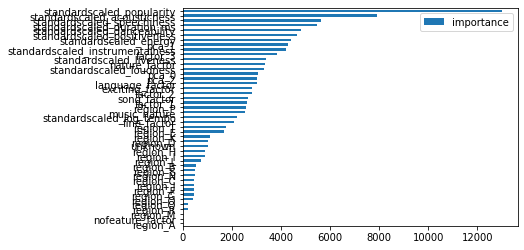

In [26]:
LightGBMimportance(importance,train_X)

In [27]:
features = [
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo',
    'pca_0','pca_1','pca_2','factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor','fine_factor','nofeature_factor','song_factor'
    ]

data = df[features]
data.head()

,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,...,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,fine_factor,nofeature_factor,song_factor
0,-1.866000,-0.499932,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,...,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,-3.352774,4.338655,5.768700
1,1.728761,0.812810,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,...,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.206800,-0.588519,-0.062652
2,0.117317,-0.547223,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,...,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-1.177654,-0.314395,-0.704443
3,0.241274,0.722347,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,...,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,-1.899606,-0.256881,0.382009
4,0.985018,0.432123,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,...,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,3.458514,0.069233,0.993303


In [31]:
model_lgb = LightGBM(train_X,train_y)

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5702
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 24
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[198]	valid_0's multi_logloss: 1.30895
[199]	valid_0's multi_logloss: 1.30884
[200]	valid_0's multi_logloss: 1.30909
[201]	valid_0's multi_logloss: 1.30912
[202]	valid_0's multi_logloss: 1.30902
[203]	valid_0's multi_logloss: 1.30886
[204]	valid_0's multi_logloss: 1.3089
[205]	valid_0's multi_logloss: 1.3086
[206]	valid_0's multi_logloss: 1.30879
[207]	valid_0's multi_logloss: 1.30878
[208]	valid_0's multi_logloss: 1.30869
[209]	valid_0's multi_logloss: 1.30883
[210]	valid_0's multi_logloss: 1.309
[211]	valid_0's multi_logloss: 1.30907
[212]	valid_0's multi_logloss: 1.30902
[213]	valid_0's multi_logloss: 1.30913
[214]	valid_0's multi_logloss: 1.30904
[215]	valid_0's multi_logloss: 1.30894
[216]	valid_0's multi_logloss: 1.30905
[217]	valid_0's multi_logloss: 1.30898
[218]	valid_0's multi_logloss: 1.3091
[219]	valid_0's multi_logloss: 1.30928
[220]	valid_0's multi_logloss: 1.3094
[221]	valid_0's multi_logloss: 1.3095
[222]	valid_0's multi_logloss: 1.30978
[223]	valid_0's multi_logloss: 1

In [32]:
importance = model_lgb.feature_importance()

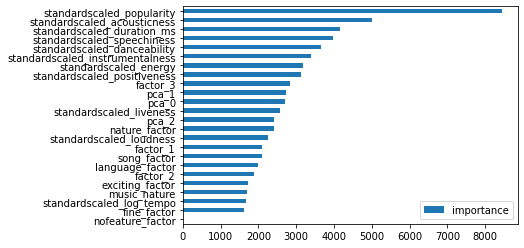

In [33]:
LightGBMimportance(importance,train_X)

In [34]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor','fine_factor','song_factor'
    ]

data = df[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_log_tempo,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,fine_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,0.544048,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,-3.352774,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,1.248860,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.206800,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,-1.978618,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-1.177654,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,1.682276,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,-1.899606,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,-0.323149,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,3.458514,0.993303


In [38]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4720
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 39
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[190]	valid_0's multi_logloss: 1.02817
[191]	valid_0's multi_logloss: 1.02782
[192]	valid_0's multi_logloss: 1.0273
[193]	valid_0's multi_logloss: 1.02669
[194]	valid_0's multi_logloss: 1.02615
[195]	valid_0's multi_logloss: 1.02582
[196]	valid_0's multi_logloss: 1.02538
[197]	valid_0's multi_logloss: 1.02468
[198]	valid_0's multi_logloss: 1.02403
[199]	valid_0's multi_logloss: 1.02347
[200]	valid_0's multi_logloss: 1.02252
[201]	valid_0's multi_logloss: 1.02199
[202]	valid_0's multi_logloss: 1.02161
[203]	valid_0's multi_logloss: 1.02107
[204]	valid_0's multi_logloss: 1.0208
[205]	valid_0's multi_logloss: 1.02058
[206]	valid_0's multi_logloss: 1.02006
[207]	valid_0's multi_logloss: 1.01991
[208]	valid_0's multi_logloss: 1.01971
[209]	valid_0's multi_logloss: 1.01915
[210]	valid_0's multi_logloss: 1.01885
[211]	valid_0's multi_logloss: 1.01848
[212]	valid_0's multi_logloss: 1.01809
[213]	valid_0's multi_logloss: 1.01806
[214]	valid_0's multi_logloss: 1.0179
[215]	valid_0's multi_loglos

[406]	valid_0's multi_logloss: 0.992744
[407]	valid_0's multi_logloss: 0.992615
[408]	valid_0's multi_logloss: 0.992843
[409]	valid_0's multi_logloss: 0.992949
[410]	valid_0's multi_logloss: 0.99331
[411]	valid_0's multi_logloss: 0.993437
[412]	valid_0's multi_logloss: 0.993467
[413]	valid_0's multi_logloss: 0.993619
[414]	valid_0's multi_logloss: 0.993775
[415]	valid_0's multi_logloss: 0.993902
[416]	valid_0's multi_logloss: 0.99388
[417]	valid_0's multi_logloss: 0.993675
[418]	valid_0's multi_logloss: 0.99379
[419]	valid_0's multi_logloss: 0.993931
[420]	valid_0's multi_logloss: 0.993897
[421]	valid_0's multi_logloss: 0.994007
[422]	valid_0's multi_logloss: 0.994018
[423]	valid_0's multi_logloss: 0.99412
[424]	valid_0's multi_logloss: 0.994167
[425]	valid_0's multi_logloss: 0.994326
[426]	valid_0's multi_logloss: 0.994467
[427]	valid_0's multi_logloss: 0.994698
[428]	valid_0's multi_logloss: 0.994805
[429]	valid_0's multi_logloss: 0.994936
[430]	valid_0's multi_logloss: 0.995164
[431

In [39]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [40]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(+factor_compornents).csv", header=None, index=False)

In [43]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor','song_factor'
    ]

data = df[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_log_tempo,pca_0,pca_1,pca_2,music_nature,nature_factor,exciting_factor,language_factor,fine_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,0.544048,-0.261937,5.044936,2.521302,5.742936,1.907340,0.985881,2.849715,-3.352774,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,1.248860,-1.661705,0.255611,-1.272544,-0.863710,0.857923,-0.795320,-0.926314,-0.206800,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,-1.978618,1.268983,0.030598,0.715309,-0.393039,-0.566170,-1.492048,1.665179,-1.177654,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,1.682276,-1.407780,1.502747,-0.809620,0.068024,1.212081,-2.156487,1.012429,-1.899606,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,-0.323149,-1.798215,-1.600899,0.474826,3.675958,0.513928,3.527748,-0.365718,3.458514,0.993303


In [49]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4720
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 39
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[183]	valid_0's multi_logloss: 1.0367
[184]	valid_0's multi_logloss: 1.03604
[185]	valid_0's multi_logloss: 1.03516
[186]	valid_0's multi_logloss: 1.03454
[187]	valid_0's multi_logloss: 1.03378
[188]	valid_0's multi_logloss: 1.03307
[189]	valid_0's multi_logloss: 1.03231
[190]	valid_0's multi_logloss: 1.03197
[191]	valid_0's multi_logloss: 1.03137
[192]	valid_0's multi_logloss: 1.03079
[193]	valid_0's multi_logloss: 1.03054
[194]	valid_0's multi_logloss: 1.02993
[195]	valid_0's multi_logloss: 1.02952
[196]	valid_0's multi_logloss: 1.02881
[197]	valid_0's multi_logloss: 1.02838
[198]	valid_0's multi_logloss: 1.02764
[199]	valid_0's multi_logloss: 1.02696
[200]	valid_0's multi_logloss: 1.02651
[201]	valid_0's multi_logloss: 1.02575
[202]	valid_0's multi_logloss: 1.02537
[203]	valid_0's multi_logloss: 1.02481
[204]	valid_0's multi_logloss: 1.02436
[205]	valid_0's multi_logloss: 1.02389
[206]	valid_0's multi_logloss: 1.02355
[207]	valid_0's multi_logloss: 1.02305
[208]	valid_0's multi_logl

[391]	valid_0's multi_logloss: 0.997399
[392]	valid_0's multi_logloss: 0.99734
[393]	valid_0's multi_logloss: 0.997381
[394]	valid_0's multi_logloss: 0.997388
[395]	valid_0's multi_logloss: 0.997563
[396]	valid_0's multi_logloss: 0.997786
[397]	valid_0's multi_logloss: 0.997708
[398]	valid_0's multi_logloss: 0.997673
[399]	valid_0's multi_logloss: 0.99775
[400]	valid_0's multi_logloss: 0.997476
[401]	valid_0's multi_logloss: 0.997684
[402]	valid_0's multi_logloss: 0.997932
[403]	valid_0's multi_logloss: 0.998152
[404]	valid_0's multi_logloss: 0.998255
[405]	valid_0's multi_logloss: 0.998034
[406]	valid_0's multi_logloss: 0.998456
[407]	valid_0's multi_logloss: 0.998728
[408]	valid_0's multi_logloss: 0.99888
[409]	valid_0's multi_logloss: 0.998976
[410]	valid_0's multi_logloss: 0.998921
[411]	valid_0's multi_logloss: 0.999079
[412]	valid_0's multi_logloss: 0.999012
[413]	valid_0's multi_logloss: 0.999104
[414]	valid_0's multi_logloss: 0.999187
[415]	valid_0's multi_logloss: 0.999067
[41

In [50]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,8
9,4055,10


In [51]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(pca).csv", header=None, index=False)

In [52]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor','song_factor'
    ]

data = df[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,standardscaled_log_tempo,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,0.544048,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,1.248860,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,-1.978618,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,1.682276,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,-0.323149,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303


In [9]:
input = Path('input')
data.to_csv(input / "features_data.csv",index=False)

NameError: name 'data' is not defined

In [66]:
input = Path('input')
features_data = pd.read_csv(input / 'features_data.csv')
sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']
df = pd.read_csv(input / 'join_data.csv')
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor,tempo_log,standardscaled_tempo
0,0,0,0,0,0,0,0,1,0,0,...,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700,4.916325,0.549758
1,0,0,0,0,0,0,0,0,1,0,...,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652,5.102911,1.269242
2,0,0,0,0,1,0,0,0,0,0,...,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443,4.248495,-2.025425
3,0,0,1,0,0,0,0,0,0,0,...,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009,5.217649,1.711681
4,0,0,0,0,0,0,0,0,0,0,...,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303,4.686750,-0.335492


In [20]:
#train_X = features_data.drop(['cluster','standardscaled_log_tempo','standardscaled_tempo'],axis=1)
train_y = df['genre'][:train_len]
#test_X = features_data.drop(['cluster','standardscaled_log_tempo','standardscaled_tempo'],axis=1)

In [21]:
train_X = features_data[:train_len]
test_X = features_data[train_len:]

In [22]:
print(train_X.shape)
print(test_X.shape)

(4046, 40)
(4046, 40)


In [109]:
model_lgb = LightGBM(train_X,train_y)

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4463
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[186]	valid_0's multi_logloss: 1.0225
[187]	valid_0's multi_logloss: 1.02214
[188]	valid_0's multi_logloss: 1.02157
[189]	valid_0's multi_logloss: 1.02116
[190]	valid_0's multi_logloss: 1.02057
[191]	valid_0's multi_logloss: 1.02018
[192]	valid_0's multi_logloss: 1.01989
[193]	valid_0's multi_logloss: 1.01958
[194]	valid_0's multi_logloss: 1.01922
[195]	valid_0's multi_logloss: 1.01903
[196]	valid_0's multi_logloss: 1.01851
[197]	valid_0's multi_logloss: 1.01816
[198]	valid_0's multi_logloss: 1.01753
[199]	valid_0's multi_logloss: 1.01699
[200]	valid_0's multi_logloss: 1.01678
[201]	valid_0's multi_logloss: 1.01616
[202]	valid_0's multi_logloss: 1.01592
[203]	valid_0's multi_logloss: 1.01557
[204]	valid_0's multi_logloss: 1.01494
[205]	valid_0's multi_logloss: 1.01453
[206]	valid_0's multi_logloss: 1.01436
[207]	valid_0's multi_logloss: 1.01386
[208]	valid_0's multi_logloss: 1.01342
[209]	valid_0's multi_logloss: 1.01306
[210]	valid_0's multi_logloss: 1.01266
[211]	valid_0's multi_logl

[398]	valid_0's multi_logloss: 0.984496
[399]	valid_0's multi_logloss: 0.984506
[400]	valid_0's multi_logloss: 0.984499
[401]	valid_0's multi_logloss: 0.984513
[402]	valid_0's multi_logloss: 0.984799
[403]	valid_0's multi_logloss: 0.985118
[404]	valid_0's multi_logloss: 0.985343
[405]	valid_0's multi_logloss: 0.985488
[406]	valid_0's multi_logloss: 0.985535
[407]	valid_0's multi_logloss: 0.985731
[408]	valid_0's multi_logloss: 0.985771
[409]	valid_0's multi_logloss: 0.986166
[410]	valid_0's multi_logloss: 0.986354
[411]	valid_0's multi_logloss: 0.986618
[412]	valid_0's multi_logloss: 0.986423
[413]	valid_0's multi_logloss: 0.986627
[414]	valid_0's multi_logloss: 0.986779
[415]	valid_0's multi_logloss: 0.986774
[416]	valid_0's multi_logloss: 0.9871
[417]	valid_0's multi_logloss: 0.987156
[418]	valid_0's multi_logloss: 0.987254
[419]	valid_0's multi_logloss: 0.987482
[420]	valid_0's multi_logloss: 0.987598
[421]	valid_0's multi_logloss: 0.987808
[422]	valid_0's multi_logloss: 0.98781
[42

In [95]:
importance = model_lgb.feature_importance()

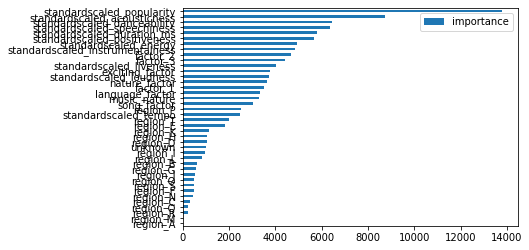

In [96]:
LightGBMimportance(importance,train_X)

In [110]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4463
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[184]	valid_0's multi_logloss: 1.02405
[185]	valid_0's multi_logloss: 1.02315
[186]	valid_0's multi_logloss: 1.0225
[187]	valid_0's multi_logloss: 1.02214
[188]	valid_0's multi_logloss: 1.02157
[189]	valid_0's multi_logloss: 1.02116
[190]	valid_0's multi_logloss: 1.02057
[191]	valid_0's multi_logloss: 1.02018
[192]	valid_0's multi_logloss: 1.01989
[193]	valid_0's multi_logloss: 1.01958
[194]	valid_0's multi_logloss: 1.01922
[195]	valid_0's multi_logloss: 1.01903
[196]	valid_0's multi_logloss: 1.01851
[197]	valid_0's multi_logloss: 1.01816
[198]	valid_0's multi_logloss: 1.01753
[199]	valid_0's multi_logloss: 1.01699
[200]	valid_0's multi_logloss: 1.01678
[201]	valid_0's multi_logloss: 1.01616
[202]	valid_0's multi_logloss: 1.01592
[203]	valid_0's multi_logloss: 1.01557
[204]	valid_0's multi_logloss: 1.01494
[205]	valid_0's multi_logloss: 1.01453
[206]	valid_0's multi_logloss: 1.01436
[207]	valid_0's multi_logloss: 1.01386
[208]	valid_0's multi_logloss: 1.01342
[209]	valid_0's multi_logl

[400]	valid_0's multi_logloss: 0.984499
[401]	valid_0's multi_logloss: 0.984513
[402]	valid_0's multi_logloss: 0.984799
[403]	valid_0's multi_logloss: 0.985118
[404]	valid_0's multi_logloss: 0.985343
[405]	valid_0's multi_logloss: 0.985488
[406]	valid_0's multi_logloss: 0.985535
[407]	valid_0's multi_logloss: 0.985731
[408]	valid_0's multi_logloss: 0.985771
[409]	valid_0's multi_logloss: 0.986166
[410]	valid_0's multi_logloss: 0.986354
[411]	valid_0's multi_logloss: 0.986618
[412]	valid_0's multi_logloss: 0.986423
[413]	valid_0's multi_logloss: 0.986627
[414]	valid_0's multi_logloss: 0.986779
[415]	valid_0's multi_logloss: 0.986774
[416]	valid_0's multi_logloss: 0.9871
[417]	valid_0's multi_logloss: 0.987156
[418]	valid_0's multi_logloss: 0.987254
[419]	valid_0's multi_logloss: 0.987482
[420]	valid_0's multi_logloss: 0.987598
[421]	valid_0's multi_logloss: 0.987808
[422]	valid_0's multi_logloss: 0.98781
[423]	valid_0's multi_logloss: 0.988057
[424]	valid_0's multi_logloss: 0.988257
[42

In [111]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [99]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(chage_tempo).csv", header=None, index=False)

In [114]:
features_data['standardscaled_tempo_log'] = np.log(features_data['standardscaled_tempo'])

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [101]:
train_X = features_data.drop('standardscaled_tempo',axis=1)
train_y = df['genre'][:train_len]
test_X = features_data.drop('standardscaled_tempo',axis=1)

In [102]:
train_X = train_X[:train_len]
test_X = test_X[train_len:]

In [112]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(chage_tempo_log).csv", header=None, index=False)

In [115]:
train_X = features_data.drop(['cluster','standardscaled_log_tempo','standardscaled_tempo'],axis=1)

In [16]:
train_X.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor,standardscaled_tempo_log
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700,-0.726893
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652,0.355492
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443,NaN
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009,0.742315
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303,NaN


In [117]:
train_X.shape

(8092, 40)

In [118]:
train_X.to_csv(input / 'features_data.csv',index=False)

In [17]:
features_data['standardscaled_tempo_log'].isnull().sum()

4069

In [25]:
model_lgb = LightGBM(train_X,train_y)

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4468
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[183]	valid_0's multi_logloss: 1.02845
[184]	valid_0's multi_logloss: 1.02755
[185]	valid_0's multi_logloss: 1.02689
[186]	valid_0's multi_logloss: 1.02611
[187]	valid_0's multi_logloss: 1.02554
[188]	valid_0's multi_logloss: 1.02495
[189]	valid_0's multi_logloss: 1.02437
[190]	valid_0's multi_logloss: 1.02376
[191]	valid_0's multi_logloss: 1.02333
[192]	valid_0's multi_logloss: 1.02246
[193]	valid_0's multi_logloss: 1.0218
[194]	valid_0's multi_logloss: 1.02156
[195]	valid_0's multi_logloss: 1.02076
[196]	valid_0's multi_logloss: 1.02046
[197]	valid_0's multi_logloss: 1.01972
[198]	valid_0's multi_logloss: 1.01917
[199]	valid_0's multi_logloss: 1.01851
[200]	valid_0's multi_logloss: 1.01788
[201]	valid_0's multi_logloss: 1.01751
[202]	valid_0's multi_logloss: 1.01746
[203]	valid_0's multi_logloss: 1.0169
[204]	valid_0's multi_logloss: 1.01656
[205]	valid_0's multi_logloss: 1.01613
[206]	valid_0's multi_logloss: 1.01582
[207]	valid_0's multi_logloss: 1.01544
[208]	valid_0's multi_loglo

[395]	valid_0's multi_logloss: 0.990428
[396]	valid_0's multi_logloss: 0.990576
[397]	valid_0's multi_logloss: 0.990516
[398]	valid_0's multi_logloss: 0.990717
[399]	valid_0's multi_logloss: 0.990785
[400]	valid_0's multi_logloss: 0.990999
[401]	valid_0's multi_logloss: 0.991156
[402]	valid_0's multi_logloss: 0.991351
[403]	valid_0's multi_logloss: 0.991306
[404]	valid_0's multi_logloss: 0.991579
[405]	valid_0's multi_logloss: 0.991778
[406]	valid_0's multi_logloss: 0.991835
[407]	valid_0's multi_logloss: 0.992015
[408]	valid_0's multi_logloss: 0.992171
[409]	valid_0's multi_logloss: 0.992313
[410]	valid_0's multi_logloss: 0.99233
[411]	valid_0's multi_logloss: 0.992362
[412]	valid_0's multi_logloss: 0.992374
[413]	valid_0's multi_logloss: 0.992421
[414]	valid_0's multi_logloss: 0.992834
[415]	valid_0's multi_logloss: 0.99303
[416]	valid_0's multi_logloss: 0.993076
[417]	valid_0's multi_logloss: 0.993341
[418]	valid_0's multi_logloss: 0.993649
[419]	valid_0's multi_logloss: 0.993753
[4

In [26]:
sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

In [27]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [28]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(chage_tempore).csv", header=None, index=False)

In [30]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_A                         8092 non-null   int64  
 1   region_B                         8092 non-null   int64  
 2   region_C                         8092 non-null   int64  
 3   region_D                         8092 non-null   int64  
 4   region_E                         8092 non-null   int64  
 5   region_F                         8092 non-null   int64  
 6   region_G                         8092 non-null   int64  
 7   region_H                         8092 non-null   int64  
 8   region_I                         8092 non-null   int64  
 9   region_J                         8092 non-null   int64  
 10  region_K                         8092 non-null   int64  
 11  region_L                         8092 non-null   int64  
 12  region_M            

In [31]:
features_data['standardscaled_popularity'].head()

0   -1.866000
1    1.728761
2    0.117317
3    0.241274
4    0.985018
Name: standardscaled_popularity, dtype: float64

In [34]:
df['popularity'].head()

0    11
1    69
2    43
3    45
4    57
Name: popularity, dtype: int64

In [67]:
features_data['popularity_log'] = np.log(df['popularity'])

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
df['duration_ms'].head()

0    201094
1    308493
2    197225
3    301092
4    277348
Name: duration_ms, dtype: int64

In [68]:
features_data['duration_ms_log'] = np.log(df['duration_ms'])
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor,tempo_log,standardscaled_tempo,popularity_log,duration_ms_log
0,0,0,0,0,0,0,0,1,0,0,...,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700,4.916325,0.549758,2.397895,12.211528
1,0,0,0,0,0,0,0,0,1,0,...,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652,5.102911,1.269242,4.234107,12.639454
2,0,0,0,0,1,0,0,0,0,0,...,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443,4.248495,-2.025425,3.761200,12.192100
3,0,0,1,0,0,0,0,0,0,0,...,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009,5.217649,1.711681,3.806662,12.615171
4,0,0,0,0,0,0,0,0,0,0,...,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303,4.686750,-0.335492,4.043051,12.533028


In [80]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'popularity_log', 'duration_ms_log',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'tempo_log',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor','song_factor'
    ]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,tempo_log,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,4.916325,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,5.102911,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,4.248495,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,5.217649,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,4.686750,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_A                         8092 non-null   int64  
 1   region_B                         8092 non-null   int64  
 2   region_C                         8092 non-null   int64  
 3   region_D                         8092 non-null   int64  
 4   region_E                         8092 non-null   int64  
 5   region_F                         8092 non-null   int64  
 6   region_G                         8092 non-null   int64  
 7   region_H                         8092 non-null   int64  
 8   region_I                         8092 non-null   int64  
 9   region_J                         8092 non-null   int64  
 10  region_K                         8092 non-null   int64  
 11  region_L                         8092 non-null   int64  
 12  region_M            

In [62]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [63]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4467
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[184]	valid_0's multi_logloss: 1.03077
[185]	valid_0's multi_logloss: 1.03003
[186]	valid_0's multi_logloss: 1.02942
[187]	valid_0's multi_logloss: 1.029
[188]	valid_0's multi_logloss: 1.02827
[189]	valid_0's multi_logloss: 1.02762
[190]	valid_0's multi_logloss: 1.02713
[191]	valid_0's multi_logloss: 1.02664
[192]	valid_0's multi_logloss: 1.0263
[193]	valid_0's multi_logloss: 1.02589
[194]	valid_0's multi_logloss: 1.02543
[195]	valid_0's multi_logloss: 1.02519
[196]	valid_0's multi_logloss: 1.02489
[197]	valid_0's multi_logloss: 1.02476
[198]	valid_0's multi_logloss: 1.02408
[199]	valid_0's multi_logloss: 1.02375
[200]	valid_0's multi_logloss: 1.0232
[201]	valid_0's multi_logloss: 1.02276
[202]	valid_0's multi_logloss: 1.02246
[203]	valid_0's multi_logloss: 1.02209
[204]	valid_0's multi_logloss: 1.02179
[205]	valid_0's multi_logloss: 1.02141
[206]	valid_0's multi_logloss: 1.02089
[207]	valid_0's multi_logloss: 1.02041
[208]	valid_0's multi_logloss: 1.02005
[209]	valid_0's multi_logloss

[395]	valid_0's multi_logloss: 0.9916
[396]	valid_0's multi_logloss: 0.991875
[397]	valid_0's multi_logloss: 0.991824
[398]	valid_0's multi_logloss: 0.992156
[399]	valid_0's multi_logloss: 0.992278
[400]	valid_0's multi_logloss: 0.992188
[401]	valid_0's multi_logloss: 0.992308
[402]	valid_0's multi_logloss: 0.992398
[403]	valid_0's multi_logloss: 0.992217
[404]	valid_0's multi_logloss: 0.992249
[405]	valid_0's multi_logloss: 0.992415
[406]	valid_0's multi_logloss: 0.992591
[407]	valid_0's multi_logloss: 0.992666
[408]	valid_0's multi_logloss: 0.992825
[409]	valid_0's multi_logloss: 0.992711
[410]	valid_0's multi_logloss: 0.992614
[411]	valid_0's multi_logloss: 0.992817
[412]	valid_0's multi_logloss: 0.99298
[413]	valid_0's multi_logloss: 0.993201
[414]	valid_0's multi_logloss: 0.993365
[415]	valid_0's multi_logloss: 0.993552
[416]	valid_0's multi_logloss: 0.993627
[417]	valid_0's multi_logloss: 0.993774
[418]	valid_0's multi_logloss: 0.993857
[419]	valid_0's multi_logloss: 0.993995
[42

In [64]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [65]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(CHANGEpopularityANDduration_msANDtempo).csv", header=None, index=False)

In [69]:
from sklearn.preprocessing import StandardScaler

for col in [
    'music_nature',
    'nature_factor','exciting_factor','language_factor','song_factor'
]:
    features_data["standardscaled_" + col] = StandardScaler().fit_transform(features_data[[col]])[:, 0]
    


In [70]:
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,song_factor,tempo_log,standardscaled_tempo,popularity_log,duration_ms_log,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,5.768700,4.916325,0.549758,2.397895,12.211528,1.952759,1.376804,0.558640,1.900288,4.313044
1,0,0,0,0,0,0,0,0,1,0,...,-0.062652,5.102911,1.269242,4.234107,12.639454,-0.293686,0.619288,-0.450660,-0.617698,-0.046843
2,0,0,0,0,1,0,0,0,0,0,...,-0.704443,4.248495,-2.025425,3.761200,12.192100,-0.133644,-0.408687,-0.845454,1.110399,-0.526686
3,0,0,1,0,0,0,0,0,0,0,...,0.382009,5.217649,1.711681,3.806662,12.615171,0.023130,0.874935,-1.221952,0.675123,0.285614
4,0,0,0,0,0,0,0,0,0,0,...,0.993303,4.686750,-0.335492,4.043051,12.533028,1.249929,0.370976,1.998963,-0.243873,0.742656


In [82]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'popularity_log', 'duration_ms_log',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_tempo',
    'factor_1','factor_2','factor_3','standardscaled_music_nature',
    'standardscaled_nature_factor','standardscaled_exciting_factor','standardscaled_language_factor','standardscaled_song_factor'
    ]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,standardscaled_tempo,factor_1,factor_2,factor_3,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,0.549758,-1.420504,2.259227,-0.021925,1.952759,1.376804,0.558640,1.900288,4.313044
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,1.269242,-1.265113,0.284038,0.253307,-0.293686,0.619288,-0.450660,-0.617698,-0.046843
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,-2.025425,0.808452,0.326082,-0.240502,-0.133644,-0.408687,-0.845454,1.110399,-0.526686
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,1.711681,-1.235781,1.103026,0.207864,0.023130,0.874935,-1.221952,0.675123,0.285614
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,-0.335492,-0.324308,-1.586230,-0.732366,1.249929,0.370976,1.998963,-0.243873,0.742656


In [84]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [85]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4467
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[188]	valid_0's multi_logloss: 1.02827
[189]	valid_0's multi_logloss: 1.02762
[190]	valid_0's multi_logloss: 1.02713
[191]	valid_0's multi_logloss: 1.02664
[192]	valid_0's multi_logloss: 1.0263
[193]	valid_0's multi_logloss: 1.02589
[194]	valid_0's multi_logloss: 1.02543
[195]	valid_0's multi_logloss: 1.02519
[196]	valid_0's multi_logloss: 1.02489
[197]	valid_0's multi_logloss: 1.02476
[198]	valid_0's multi_logloss: 1.02408
[199]	valid_0's multi_logloss: 1.02375
[200]	valid_0's multi_logloss: 1.0232
[201]	valid_0's multi_logloss: 1.02276
[202]	valid_0's multi_logloss: 1.02246
[203]	valid_0's multi_logloss: 1.02209
[204]	valid_0's multi_logloss: 1.02179
[205]	valid_0's multi_logloss: 1.02141
[206]	valid_0's multi_logloss: 1.02089
[207]	valid_0's multi_logloss: 1.02041
[208]	valid_0's multi_logloss: 1.02005
[209]	valid_0's multi_logloss: 1.01964
[210]	valid_0's multi_logloss: 1.0192
[211]	valid_0's multi_logloss: 1.01895
[212]	valid_0's multi_logloss: 1.01851
[213]	valid_0's multi_loglos

[400]	valid_0's multi_logloss: 0.992188
[401]	valid_0's multi_logloss: 0.992308
[402]	valid_0's multi_logloss: 0.992398
[403]	valid_0's multi_logloss: 0.992217
[404]	valid_0's multi_logloss: 0.992249
[405]	valid_0's multi_logloss: 0.992415
[406]	valid_0's multi_logloss: 0.992591
[407]	valid_0's multi_logloss: 0.992666
[408]	valid_0's multi_logloss: 0.992825
[409]	valid_0's multi_logloss: 0.992711
[410]	valid_0's multi_logloss: 0.992614
[411]	valid_0's multi_logloss: 0.992817
[412]	valid_0's multi_logloss: 0.99298
[413]	valid_0's multi_logloss: 0.993201
[414]	valid_0's multi_logloss: 0.993365
[415]	valid_0's multi_logloss: 0.993552
[416]	valid_0's multi_logloss: 0.993627
[417]	valid_0's multi_logloss: 0.993774
[418]	valid_0's multi_logloss: 0.993857
[419]	valid_0's multi_logloss: 0.993995
[420]	valid_0's multi_logloss: 0.99411
[421]	valid_0's multi_logloss: 0.994285
[422]	valid_0's multi_logloss: 0.994196
[423]	valid_0's multi_logloss: 0.994343
[424]	valid_0's multi_logloss: 0.994451
[4

In [79]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [75]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(factor_scaled).csv", header=None, index=False)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_A                         8092 non-null   int64  
 1   region_B                         8092 non-null   int64  
 2   region_C                         8092 non-null   int64  
 3   region_D                         8092 non-null   int64  
 4   region_E                         8092 non-null   int64  
 5   region_F                         8092 non-null   int64  
 6   region_G                         8092 non-null   int64  
 7   region_H                         8092 non-null   int64  
 8   region_I                         8092 non-null   int64  
 9   region_J                         8092 non-null   int64  
 10  region_K                         8092 non-null   int64  
 11  region_L                         8092 non-null   int64  
 12  region_M            

In [125]:
features_data = pd.read_csv(input / 'features_data.csv')
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,tempo_log,standardscaled_tempo,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3
0,0,0,0,0,0,0,0,1,0,0,...,4.916325,0.549758,1.952759,1.376804,0.558640,1.900288,4.313044,-1.437596,2.634747,-0.028074
1,0,0,0,0,0,0,0,0,1,0,...,5.102911,1.269242,-0.293686,0.619288,-0.450660,-0.617698,-0.046843,-1.280335,0.331250,0.324341
2,0,0,0,0,1,0,0,0,0,0,...,4.248495,-2.025425,-0.133644,-0.408687,-0.845454,1.110399,-0.526686,0.818180,0.380283,-0.307946
3,0,0,1,0,0,0,0,0,0,0,...,5.217649,1.711681,0.023130,0.874935,-1.221952,0.675123,0.285614,-1.250650,1.286367,0.266155
4,0,0,0,0,0,0,0,0,0,0,...,4.686750,-0.335492,1.249929,0.370976,1.998963,-0.243873,0.742656,-0.328210,-1.849888,-0.937742


In [123]:
for col in ['music_nature','nature_factor','exciting_factor','language_factor','song_factor']:
    features_data['log_' + col] = np.log(features_data[col])
features_data.head()

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_language_factor,standardscaled_song_factor,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3,log_music_nature,log_nature_factor,log_exciting_factor,log_language_factor,log_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,1.900288,4.313044,-1.437596,2.634747,-0.028074,1.747971,0.645710,-0.01422,1.047219,1.752447
1,0,0,0,0,0,0,0,0,1,0,...,-0.617698,-0.046843,-1.280335,0.331250,0.324341,NaN,-0.153240,NaN,NaN,NaN
2,0,0,0,0,1,0,0,0,0,0,...,1.110399,-0.526686,0.818180,0.380283,-0.307946,NaN,NaN,NaN,0.509933,NaN
3,0,0,1,0,0,0,0,0,0,0,...,0.675123,0.285614,-1.250650,1.286367,0.266155,-2.687901,0.192339,NaN,0.012353,-0.962311
4,0,0,0,0,0,0,0,0,0,0,...,-0.243873,0.742656,-0.328210,-1.849888,-0.937742,1.301814,-0.665673,1.26066,NaN,-0.006719


In [126]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_A                         8092 non-null   int64  
 1   region_B                         8092 non-null   int64  
 2   region_C                         8092 non-null   int64  
 3   region_D                         8092 non-null   int64  
 4   region_E                         8092 non-null   int64  
 5   region_F                         8092 non-null   int64  
 6   region_G                         8092 non-null   int64  
 7   region_H                         8092 non-null   int64  
 8   region_I                         8092 non-null   int64  
 9   region_J                         8092 non-null   int64  
 10  region_K                         8092 non-null   int64  
 11  region_L                         8092 non-null   int64  
 12  region_M            

In [124]:
from sklearn.preprocessing import StandardScaler

for col in [
    'music_nature',
    'nature_factor','exciting_factor','language_factor','song_factor',
    'factor_1','factor_2','factor_3'
]:
    features_data["standardscaled_" + col] = StandardScaler().fit_transform(features_data[[col]])[:, 0]

In [22]:
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,tempo_log,standardscaled_tempo,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3
0,0,0,0,0,0,0,0,1,0,0,...,4.916325,0.549758,1.952759,1.376804,0.558640,1.900288,4.313044,-1.437596,2.634747,-0.028074
1,0,0,0,0,0,0,0,0,1,0,...,5.102911,1.269242,-0.293686,0.619288,-0.450660,-0.617698,-0.046843,-1.280335,0.331250,0.324341
2,0,0,0,0,1,0,0,0,0,0,...,4.248495,-2.025425,-0.133644,-0.408687,-0.845454,1.110399,-0.526686,0.818180,0.380283,-0.307946
3,0,0,1,0,0,0,0,0,0,0,...,5.217649,1.711681,0.023130,0.874935,-1.221952,0.675123,0.285614,-1.250650,1.286367,0.266155
4,0,0,0,0,0,0,0,0,0,0,...,4.686750,-0.335492,1.249929,0.370976,1.998963,-0.243873,0.742656,-0.328210,-1.849888,-0.937742


In [23]:
features_data.to_csv(input / 'features_data.csv',index=False)

In [29]:
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'log_popularity', 'log_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_tempo',
    'standardscaled_factor_1','standardscaled_factor_2','standardscaled_factor_3','standardscaled_music_nature',
    'standardscaled_nature_factor','standardscaled_exciting_factor','standardscaled_language_factor','standardscaled_song_factor'
    ]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,standardscaled_tempo,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,0.549758,-1.437596,2.634747,-0.028074,1.952759,1.376804,0.558640,1.900288,4.313044
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,1.269242,-1.280335,0.331250,0.324341,-0.293686,0.619288,-0.450660,-0.617698,-0.046843
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,-2.025425,0.818180,0.380283,-0.307946,-0.133644,-0.408687,-0.845454,1.110399,-0.526686
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,1.711681,-1.250650,1.286367,0.266155,0.023130,0.874935,-1.221952,0.675123,0.285614
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,-0.335492,-0.328210,-1.849888,-0.937742,1.249929,0.370976,1.998963,-0.243873,0.742656


In [127]:
for col in ['popularity','duration_ms']:
    features_data['log_' + col] = np.log(df[col])
features_data.head()

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3,log_popularity,log_duration_ms
0,0,0,0,0,0,0,0,1,0,0,...,1.952759,1.376804,0.558640,1.900288,4.313044,-1.437596,2.634747,-0.028074,2.397895,12.211528
1,0,0,0,0,0,0,0,0,1,0,...,-0.293686,0.619288,-0.450660,-0.617698,-0.046843,-1.280335,0.331250,0.324341,4.234107,12.639454
2,0,0,0,0,1,0,0,0,0,0,...,-0.133644,-0.408687,-0.845454,1.110399,-0.526686,0.818180,0.380283,-0.307946,3.761200,12.192100
3,0,0,1,0,0,0,0,0,0,0,...,0.023130,0.874935,-1.221952,0.675123,0.285614,-1.250650,1.286367,0.266155,3.806662,12.615171
4,0,0,0,0,0,0,0,0,0,0,...,1.249929,0.370976,1.998963,-0.243873,0.742656,-0.328210,-1.849888,-0.937742,4.043051,12.533028


In [32]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [35]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4467
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[Lig

[177]	valid_0's multi_logloss: 1.09219
[178]	valid_0's multi_logloss: 1.09135
[179]	valid_0's multi_logloss: 1.09015
[180]	valid_0's multi_logloss: 1.08923
[181]	valid_0's multi_logloss: 1.08843
[182]	valid_0's multi_logloss: 1.0876
[183]	valid_0's multi_logloss: 1.08661
[184]	valid_0's multi_logloss: 1.08541
[185]	valid_0's multi_logloss: 1.08462
[186]	valid_0's multi_logloss: 1.08447
[187]	valid_0's multi_logloss: 1.08344
[188]	valid_0's multi_logloss: 1.08266
[189]	valid_0's multi_logloss: 1.08181
[190]	valid_0's multi_logloss: 1.08135
[191]	valid_0's multi_logloss: 1.08028
[192]	valid_0's multi_logloss: 1.07939
[193]	valid_0's multi_logloss: 1.07851
[194]	valid_0's multi_logloss: 1.07767
[195]	valid_0's multi_logloss: 1.07653
[196]	valid_0's multi_logloss: 1.0758
[197]	valid_0's multi_logloss: 1.07503
[198]	valid_0's multi_logloss: 1.07449
[199]	valid_0's multi_logloss: 1.07369
[200]	valid_0's multi_logloss: 1.07257
[201]	valid_0's multi_logloss: 1.0721
[202]	valid_0's multi_loglos

[394]	valid_0's multi_logloss: 1.00051
[395]	valid_0's multi_logloss: 1.00049
[396]	valid_0's multi_logloss: 1.00034
[397]	valid_0's multi_logloss: 1.00046
[398]	valid_0's multi_logloss: 1.00046
[399]	valid_0's multi_logloss: 1.00066
[400]	valid_0's multi_logloss: 1.00069
[401]	valid_0's multi_logloss: 1.00065
[402]	valid_0's multi_logloss: 1.00065
[403]	valid_0's multi_logloss: 1.00047
[404]	valid_0's multi_logloss: 1.00059
[405]	valid_0's multi_logloss: 1.00048
[406]	valid_0's multi_logloss: 1.00036
[407]	valid_0's multi_logloss: 1.00038
[408]	valid_0's multi_logloss: 1.00031
[409]	valid_0's multi_logloss: 1.00037
[410]	valid_0's multi_logloss: 1.00044
[411]	valid_0's multi_logloss: 1.00048
[412]	valid_0's multi_logloss: 1.00021
[413]	valid_0's multi_logloss: 0.999968
[414]	valid_0's multi_logloss: 0.999685
[415]	valid_0's multi_logloss: 0.999545
[416]	valid_0's multi_logloss: 0.999855
[417]	valid_0's multi_logloss: 1.00004
[418]	valid_0's multi_logloss: 0.999911
[419]	valid_0's mult

In [34]:
import lightgbm as lgb

def LightGBM(train_X,train_y):
    
    
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)
    
    lgbm_params = {
        'task':'train',
        'objective': 'multiclass', # 目的 : 多クラス分類 
        'num_class': 11, # クラス数 : 11
        "learning_rate": 0.01,
        'num_leaves':31,
        "n_estimators": 10000,
        'n_jobs': -1,
        "importance_type": "gain",
        "colsample_bytree": .5,
        'random_state':2021,
        "class_weight":"balanced"
}
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         early_stopping_rounds=100)

    
    return model_lgb

In [36]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [39]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(chagePram).csv", header=None, index=False)

In [40]:
def LightGBM(train_X,train_y):
    
    
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)
    
    lgbm_params = {
        'objective': 'multiclass', # 目的 : 多クラス分類 
        'num_class': 11, # クラス数 : 11
        "learning_rate": 0.01,
        'num_leaves':3,
        "min_data_in_leaf": 40,
        'random_state':2021,
        "verbosity": 0
}
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         early_stopping_rounds=100)

    
    return model_lgb

In [41]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.72654
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.71389
[3]	valid_0's multi_logloss: 1.70314
[4]	valid_0's multi_logloss: 1.69324
[5]	valid_0's multi_logloss: 1.6842
[6]	valid_0's multi_logloss: 1.67582
[7]	valid_0's multi_logloss: 1.66761
[8]	valid_0's multi_logloss: 1.65975
[9]	valid_0's multi_logloss: 1.65273
[10]	valid_0's multi_logloss: 1.64574
[11]	valid_0's multi_logloss: 1.63915
[12]	valid_0's multi_logloss: 1.63267
[13]	valid_0's multi_logloss: 1.62653
[14]	valid_0's multi_logloss: 1.62073
[15]	valid_0's multi_logloss: 1.61473
[16]	valid_0's multi_logloss: 1.60918
[17]	valid_0's multi_logloss: 1.60352
[18]	valid_0's multi_logloss: 1.59821
[19]	valid_0's multi_logloss: 1.59284
[20]	valid_0's multi_logloss: 1.58818
[21]	valid_0's multi_lo

In [42]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,8
4,4050,8
5,4051,8
6,4052,8
7,4053,8
8,4054,8
9,4055,10


In [43]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission(chagePram2).csv", header=None, index=False)

In [15]:
import lightgbm as lgb

def LightGBM(train_X,train_y):
    
    
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)
    
    lgbm_params = {
        'task':'train',
        'objective': 'multiclass', # 目的 : 多クラス分類 
        'num_class': 11, # クラス数 : 11
        "learning_rate": 0.01,
        'num_leaves':31,
        "n_estimators": 10000,
        'random_state':2021
}
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         early_stopping_rounds=100)

    
    return model_lgb

In [45]:
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_music_nature,standardscaled_nature_factor,standardscaled_exciting_factor,standardscaled_language_factor,standardscaled_song_factor,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3,log_popularity,log_duration_ms
0,0,0,0,0,0,0,0,1,0,0,...,1.952759,1.376804,0.558640,1.900288,4.313044,-1.437596,2.634747,-0.028074,2.397895,12.211528
1,0,0,0,0,0,0,0,0,1,0,...,-0.293686,0.619288,-0.450660,-0.617698,-0.046843,-1.280335,0.331250,0.324341,4.234107,12.639454
2,0,0,0,0,1,0,0,0,0,0,...,-0.133644,-0.408687,-0.845454,1.110399,-0.526686,0.818180,0.380283,-0.307946,3.761200,12.192100
3,0,0,1,0,0,0,0,0,0,0,...,0.023130,0.874935,-1.221952,0.675123,0.285614,-1.250650,1.286367,0.266155,3.806662,12.615171
4,0,0,0,0,0,0,0,0,0,0,...,1.249929,0.370976,1.998963,-0.243873,0.742656,-0.328210,-1.849888,-0.937742,4.043051,12.533028


In [171]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   region_A                             8092 non-null   int64  
 1   region_B                             8092 non-null   int64  
 2   region_C                             8092 non-null   int64  
 3   region_D                             8092 non-null   int64  
 4   region_E                             8092 non-null   int64  
 5   region_F                             8092 non-null   int64  
 6   region_G                             8092 non-null   int64  
 7   region_H                             8092 non-null   int64  
 8   region_I                             8092 non-null   int64  
 9   region_J                             8092 non-null   int64  
 10  region_K                             8092 non-null   int64  
 11  region_L                      

In [129]:
for col in [
    'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_tempo',
    'standardscaled_factor_1','standardscaled_factor_2','standardscaled_factor_3','standardscaled_music_nature',
    'standardscaled_nature_factor','standardscaled_exciting_factor','standardscaled_language_factor','standardscaled_song_factor',
    'standardscaled_popularity','standardscaled_duration_ms'
]:
    features_data['log_' + col] = np.log(features_data[col])
features_data.head()

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,log_standardscaled_factor_1,log_standardscaled_factor_2,log_standardscaled_factor_3,log_standardscaled_music_nature,log_standardscaled_nature_factor,log_standardscaled_exciting_factor,log_standardscaled_language_factor,log_standardscaled_song_factor,log_standardscaled_popularity,log_standardscaled_duration_ms
0,0,0,0,0,0,0,0,1,0,0,...,NaN,0.968787,NaN,0.669243,0.319765,-0.582251,0.642005,1.461644,NaN,NaN
1,0,0,0,0,0,0,0,0,1,0,...,NaN,-1.104883,-1.125958,NaN,-0.479185,NaN,NaN,NaN,0.547405,-0.207258
2,0,0,0,0,1,0,0,0,0,0,...,-0.200673,-0.966841,NaN,NaN,NaN,NaN,0.104719,NaN,-2.142878,NaN
3,0,0,1,0,0,0,0,0,0,0,...,NaN,0.251822,-1.323676,-3.766628,-0.133606,NaN,-0.392861,-1.253113,-1.421822,-0.325250
4,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0.223086,-0.991617,0.692629,NaN,-0.297522,-0.015096,-0.839045


In [49]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'log_standardscaled_popularity', 'log_standardscaled_duration_ms',
   'log_standardscaled_acousticness', 'log_standardscaled_positiveness',
   'log_standardscaled_danceability', 'log_standardscaled_loudness',
   'log_standardscaled_energy', 'log_standardscaled_liveness',
   'log_standardscaled_speechiness', 'log_standardscaled_instrumentalness',
   'log_standardscaled_tempo',
    'log_standardscaled_factor_1','log_standardscaled_factor_2','log_standardscaled_factor_3','log_standardscaled_music_nature',
    'log_standardscaled_nature_factor','log_standardscaled_exciting_factor','log_standardscaled_language_factor',
    'log_standardscaled_song_factor'
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,log_standardscaled_instrumentalness,log_standardscaled_tempo,log_standardscaled_factor_1,log_standardscaled_factor_2,log_standardscaled_factor_3,log_standardscaled_music_nature,log_standardscaled_nature_factor,log_standardscaled_exciting_factor,log_standardscaled_language_factor,log_standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,1.467564,-0.598278,NaN,0.968787,NaN,0.669243,0.319765,-0.582251,0.642005,1.461644
1,0,0,0,0,0,0,0,0,1,0,...,NaN,0.238420,NaN,-1.104883,-1.125958,NaN,-0.479185,NaN,NaN,NaN
2,0,0,0,0,1,0,0,0,0,0,...,NaN,NaN,-0.200673,-0.966841,NaN,NaN,NaN,NaN,0.104719,NaN
3,0,0,1,0,0,0,0,0,0,0,...,NaN,0.537476,NaN,0.251822,-1.323676,-3.766628,-0.133606,NaN,-0.392861,-1.253113
4,0,0,0,0,0,0,0,0,0,0,...,-2.670274,NaN,NaN,NaN,NaN,0.223086,-0.991617,0.692629,NaN,-0.297522


In [50]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [52]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4388
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[186]	valid_0's multi_logloss: 1.08031
[187]	valid_0's multi_logloss: 1.07972
[188]	valid_0's multi_logloss: 1.07885
[189]	valid_0's multi_logloss: 1.07847
[190]	valid_0's multi_logloss: 1.07789
[191]	valid_0's multi_logloss: 1.07738
[192]	valid_0's multi_logloss: 1.07693
[193]	valid_0's multi_logloss: 1.07643
[194]	valid_0's multi_logloss: 1.07624
[195]	valid_0's multi_logloss: 1.07579
[196]	valid_0's multi_logloss: 1.07533
[197]	valid_0's multi_logloss: 1.0749
[198]	valid_0's multi_logloss: 1.07441
[199]	valid_0's multi_logloss: 1.07421
[200]	valid_0's multi_logloss: 1.07388
[201]	valid_0's multi_logloss: 1.07332
[202]	valid_0's multi_logloss: 1.07293
[203]	valid_0's multi_logloss: 1.07245
[204]	valid_0's multi_logloss: 1.07191
[205]	valid_0's multi_logloss: 1.07164
[206]	valid_0's multi_logloss: 1.07141
[207]	valid_0's multi_logloss: 1.07119
[208]	valid_0's multi_logloss: 1.07083
[209]	valid_0's multi_logloss: 1.07056
[210]	valid_0's multi_logloss: 1.07021
[211]	valid_0's multi_logl

[401]	valid_0's multi_logloss: 1.0612
[402]	valid_0's multi_logloss: 1.06131
[403]	valid_0's multi_logloss: 1.06153
[404]	valid_0's multi_logloss: 1.06172
[405]	valid_0's multi_logloss: 1.06189
[406]	valid_0's multi_logloss: 1.06196
[407]	valid_0's multi_logloss: 1.06212
[408]	valid_0's multi_logloss: 1.06237
[409]	valid_0's multi_logloss: 1.06258
[410]	valid_0's multi_logloss: 1.06271
[411]	valid_0's multi_logloss: 1.06268
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 1.05359


In [53]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [54]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'log_standardscaled_popularity', 'log_standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'log_standardscaled_tempo',
    'log_standardscaled_factor_1','log_standardscaled_factor_2','log_standardscaled_factor_3','log_standardscaled_music_nature',
    'log_standardscaled_nature_factor','log_standardscaled_exciting_factor','log_standardscaled_language_factor',
    'log_standardscaled_song_factor'
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,log_standardscaled_tempo,log_standardscaled_factor_1,log_standardscaled_factor_2,log_standardscaled_factor_3,log_standardscaled_music_nature,log_standardscaled_nature_factor,log_standardscaled_exciting_factor,log_standardscaled_language_factor,log_standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,-0.598278,NaN,0.968787,NaN,0.669243,0.319765,-0.582251,0.642005,1.461644
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,0.238420,NaN,-1.104883,-1.125958,NaN,-0.479185,NaN,NaN,NaN
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,NaN,-0.200673,-0.966841,NaN,NaN,NaN,NaN,0.104719,NaN
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,0.537476,NaN,0.251822,-1.323676,-3.766628,-0.133606,NaN,-0.392861,-1.253113
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,NaN,NaN,NaN,NaN,0.223086,-0.991617,0.692629,NaN,-0.297522


In [55]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [56]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4422
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 38
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[187]	valid_0's multi_logloss: 1.07984
[188]	valid_0's multi_logloss: 1.07913
[189]	valid_0's multi_logloss: 1.07849
[190]	valid_0's multi_logloss: 1.07807
[191]	valid_0's multi_logloss: 1.07754
[192]	valid_0's multi_logloss: 1.07705
[193]	valid_0's multi_logloss: 1.07671
[194]	valid_0's multi_logloss: 1.07628
[195]	valid_0's multi_logloss: 1.07605
[196]	valid_0's multi_logloss: 1.07546
[197]	valid_0's multi_logloss: 1.0749
[198]	valid_0's multi_logloss: 1.07456
[199]	valid_0's multi_logloss: 1.07413
[200]	valid_0's multi_logloss: 1.07358
[201]	valid_0's multi_logloss: 1.073
[202]	valid_0's multi_logloss: 1.07253
[203]	valid_0's multi_logloss: 1.07214
[204]	valid_0's multi_logloss: 1.07166
[205]	valid_0's multi_logloss: 1.07116
[206]	valid_0's multi_logloss: 1.07078
[207]	valid_0's multi_logloss: 1.07026
[208]	valid_0's multi_logloss: 1.06994
[209]	valid_0's multi_logloss: 1.06943
[210]	valid_0's multi_logloss: 1.06913
[211]	valid_0's multi_logloss: 1.06879
[212]	valid_0's multi_loglos

[398]	valid_0's multi_logloss: 1.06394
[399]	valid_0's multi_logloss: 1.06412
[400]	valid_0's multi_logloss: 1.06436
[401]	valid_0's multi_logloss: 1.06441
[402]	valid_0's multi_logloss: 1.06456
[403]	valid_0's multi_logloss: 1.06481
[404]	valid_0's multi_logloss: 1.06491
[405]	valid_0's multi_logloss: 1.06505
[406]	valid_0's multi_logloss: 1.06534
[407]	valid_0's multi_logloss: 1.06538
Early stopping, best iteration is:
[307]	valid_0's multi_logloss: 1.05525


In [58]:
LightGBMSubmission.tail(20)

,index,genre
4026,8072,8
4027,8073,2
4028,8074,10
4029,8075,7
4030,8076,10
4031,8077,10
4032,8078,3
4033,8079,8
4034,8080,5
4035,8081,5


In [59]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'log_popularity', 'log_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'log_standardscaled_tempo',
    'factor_1','factor_2','factor_3','log_standardscaled_music_nature',
    'log_standardscaled_nature_factor','log_standardscaled_exciting_factor','log_standardscaled_language_factor',
    'log_standardscaled_song_factor'
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,log_standardscaled_tempo,factor_1,factor_2,factor_3,log_standardscaled_music_nature,log_standardscaled_nature_factor,log_standardscaled_exciting_factor,log_standardscaled_language_factor,log_standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,-0.598278,-1.420504,2.259227,-0.021925,0.669243,0.319765,-0.582251,0.642005,1.461644
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,0.238420,-1.265113,0.284038,0.253307,NaN,-0.479185,NaN,NaN,NaN
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,NaN,0.808452,0.326082,-0.240502,NaN,NaN,NaN,0.104719,NaN
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,0.537476,-1.235781,1.103026,0.207864,-3.766628,-0.133606,NaN,-0.392861,-1.253113
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,NaN,-0.324308,-1.586230,-0.732366,0.223086,-0.991617,0.692629,NaN,-0.297522


In [118]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [119]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4477
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 39
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[186]	valid_0's multi_logloss: 1.02591
[187]	valid_0's multi_logloss: 1.02501
[188]	valid_0's multi_logloss: 1.02458
[189]	valid_0's multi_logloss: 1.02404
[190]	valid_0's multi_logloss: 1.02374
[191]	valid_0's multi_logloss: 1.02335
[192]	valid_0's multi_logloss: 1.02305
[193]	valid_0's multi_logloss: 1.02258
[194]	valid_0's multi_logloss: 1.02211
[195]	valid_0's multi_logloss: 1.02163
[196]	valid_0's multi_logloss: 1.02128
[197]	valid_0's multi_logloss: 1.0205
[198]	valid_0's multi_logloss: 1.02018
[199]	valid_0's multi_logloss: 1.01967
[200]	valid_0's multi_logloss: 1.01922
[201]	valid_0's multi_logloss: 1.01897
[202]	valid_0's multi_logloss: 1.0185
[203]	valid_0's multi_logloss: 1.01805
[204]	valid_0's multi_logloss: 1.01772
[205]	valid_0's multi_logloss: 1.01711
[206]	valid_0's multi_logloss: 1.01666
[207]	valid_0's multi_logloss: 1.01628
[208]	valid_0's multi_logloss: 1.01599
[209]	valid_0's multi_logloss: 1.01565
[210]	valid_0's multi_logloss: 1.01517
[211]	valid_0's multi_loglo

[397]	valid_0's multi_logloss: 0.988402
[398]	valid_0's multi_logloss: 0.988566
[399]	valid_0's multi_logloss: 0.988609
[400]	valid_0's multi_logloss: 0.988583
[401]	valid_0's multi_logloss: 0.988484
[402]	valid_0's multi_logloss: 0.988381
[403]	valid_0's multi_logloss: 0.98843
[404]	valid_0's multi_logloss: 0.988387
[405]	valid_0's multi_logloss: 0.988425
[406]	valid_0's multi_logloss: 0.988655
[407]	valid_0's multi_logloss: 0.988701
[408]	valid_0's multi_logloss: 0.988856
[409]	valid_0's multi_logloss: 0.988816
[410]	valid_0's multi_logloss: 0.988912
[411]	valid_0's multi_logloss: 0.988996
[412]	valid_0's multi_logloss: 0.989045
[413]	valid_0's multi_logloss: 0.988962
[414]	valid_0's multi_logloss: 0.989194
[415]	valid_0's multi_logloss: 0.989426
[416]	valid_0's multi_logloss: 0.989543
[417]	valid_0's multi_logloss: 0.989518
[418]	valid_0's multi_logloss: 0.989564
[419]	valid_0's multi_logloss: 0.989699
[420]	valid_0's multi_logloss: 0.989929
[421]	valid_0's multi_logloss: 0.990218
[

In [62]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [63]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission2.csv", header=None, index=False)

In [67]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'log_standardscaled_tempo',
    'factor_1','factor_2','factor_3','log_standardscaled_music_nature',
    'log_standardscaled_nature_factor','log_standardscaled_exciting_factor','log_standardscaled_language_factor',
    'log_standardscaled_song_factor'
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,log_standardscaled_tempo,factor_1,factor_2,factor_3,log_standardscaled_music_nature,log_standardscaled_nature_factor,log_standardscaled_exciting_factor,log_standardscaled_language_factor,log_standardscaled_song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,-0.598278,-1.420504,2.259227,-0.021925,0.669243,0.319765,-0.582251,0.642005,1.461644
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,0.238420,-1.265113,0.284038,0.253307,NaN,-0.479185,NaN,NaN,NaN
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,NaN,0.808452,0.326082,-0.240502,NaN,NaN,NaN,0.104719,NaN
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,0.537476,-1.235781,1.103026,0.207864,-3.766628,-0.133606,NaN,-0.392861,-1.253113
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,NaN,-0.324308,-1.586230,-0.732366,0.223086,-0.991617,0.692629,NaN,-0.297522


In [111]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [112]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4477
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 39
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[187]	valid_0's multi_logloss: 1.02501
[188]	valid_0's multi_logloss: 1.02458
[189]	valid_0's multi_logloss: 1.02404
[190]	valid_0's multi_logloss: 1.02374
[191]	valid_0's multi_logloss: 1.02335
[192]	valid_0's multi_logloss: 1.02305
[193]	valid_0's multi_logloss: 1.02258
[194]	valid_0's multi_logloss: 1.02211
[195]	valid_0's multi_logloss: 1.02163
[196]	valid_0's multi_logloss: 1.02128
[197]	valid_0's multi_logloss: 1.0205
[198]	valid_0's multi_logloss: 1.02018
[199]	valid_0's multi_logloss: 1.01967
[200]	valid_0's multi_logloss: 1.01922
[201]	valid_0's multi_logloss: 1.01897
[202]	valid_0's multi_logloss: 1.0185
[203]	valid_0's multi_logloss: 1.01805
[204]	valid_0's multi_logloss: 1.01772
[205]	valid_0's multi_logloss: 1.01711
[206]	valid_0's multi_logloss: 1.01666
[207]	valid_0's multi_logloss: 1.01628
[208]	valid_0's multi_logloss: 1.01599
[209]	valid_0's multi_logloss: 1.01565
[210]	valid_0's multi_logloss: 1.01517
[211]	valid_0's multi_logloss: 1.01466
[212]	valid_0's multi_loglo

[398]	valid_0's multi_logloss: 0.988566
[399]	valid_0's multi_logloss: 0.988609
[400]	valid_0's multi_logloss: 0.988583
[401]	valid_0's multi_logloss: 0.988484
[402]	valid_0's multi_logloss: 0.988381
[403]	valid_0's multi_logloss: 0.98843
[404]	valid_0's multi_logloss: 0.988387
[405]	valid_0's multi_logloss: 0.988425
[406]	valid_0's multi_logloss: 0.988655
[407]	valid_0's multi_logloss: 0.988701
[408]	valid_0's multi_logloss: 0.988856
[409]	valid_0's multi_logloss: 0.988816
[410]	valid_0's multi_logloss: 0.988912
[411]	valid_0's multi_logloss: 0.988996
[412]	valid_0's multi_logloss: 0.989045
[413]	valid_0's multi_logloss: 0.988962
[414]	valid_0's multi_logloss: 0.989194
[415]	valid_0's multi_logloss: 0.989426
[416]	valid_0's multi_logloss: 0.989543
[417]	valid_0's multi_logloss: 0.989518
[418]	valid_0's multi_logloss: 0.989564
[419]	valid_0's multi_logloss: 0.989699
[420]	valid_0's multi_logloss: 0.989929
[421]	valid_0's multi_logloss: 0.990218
[422]	valid_0's multi_logloss: 0.990509
[

In [76]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'log_standardscaled_tempo',
    'standardscaled_factor_1','standardscaled_factor_2','standardscaled_factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor',
    'song_factor'
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_instrumentalness,log_standardscaled_tempo,standardscaled_factor_1,standardscaled_factor_2,standardscaled_factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor
0,0,0,0,0,0,0,0,1,0,0,...,4.338655,-0.598278,-1.437596,2.634747,-0.028074,5.742936,1.907340,0.985881,2.849715,5.768700
1,0,0,0,0,0,0,0,0,1,0,...,-0.588519,0.238420,-1.280335,0.331250,0.324341,-0.863710,0.857923,-0.795320,-0.926314,-0.062652
2,0,0,0,0,1,0,0,0,0,0,...,-0.314395,NaN,0.818180,0.380283,-0.307946,-0.393039,-0.566170,-1.492048,1.665179,-0.704443
3,0,0,1,0,0,0,0,0,0,0,...,-0.256881,0.537476,-1.250650,1.286367,0.266155,0.068024,1.212081,-2.156487,1.012429,0.382009
4,0,0,0,0,0,0,0,0,0,0,...,0.069233,NaN,-0.328210,-1.849888,-0.937742,3.675958,0.513928,3.527748,-0.365718,0.993303


In [130]:
features_data['tempo_max'] = df['tempo'].map(lambda x: max(map(int, x.split("-"))))
features_data['tempo_min'] = df['tempo'].map(lambda x: min(map(int, x.split("-"))))
features_data['tempo_diff'] = features_data['tempo_max'] - features_data['tempo_min']
features_data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,log_standardscaled_music_nature,log_standardscaled_nature_factor,log_standardscaled_exciting_factor,log_standardscaled_language_factor,log_standardscaled_song_factor,log_standardscaled_popularity,log_standardscaled_duration_ms,tempo_max,tempo_min,tempo_diff
0,0,0,0,0,0,0,0,1,0,0,...,0.669243,0.319765,-0.582251,0.642005,1.461644,NaN,NaN,152,121,31
1,0,0,0,0,0,0,0,0,1,0,...,NaN,-0.479185,NaN,NaN,NaN,0.547405,-0.207258,176,153,23
2,0,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,0.104719,NaN,-2.142878,NaN,76,64,12
3,0,0,1,0,0,0,0,0,0,0,...,-3.766628,-0.133606,NaN,-0.392861,-1.253113,-1.421822,-0.325250,192,177,15
4,0,0,0,0,0,0,0,0,0,0,...,0.223086,-0.991617,0.692629,NaN,-0.297522,-0.015096,-0.839045,120,97,23


In [117]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   #'log_standardscaled_tempo',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor',
    'song_factor','log_tempo_max','log_tempo_diff'
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor,log_tempo_max,log_tempo_diff
0,0,0,0,0,0,0,0,1,0,0,...,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700,5.023881,3.433987
1,0,0,0,0,0,0,0,0,1,0,...,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652,5.170484,3.135494
2,0,0,0,0,1,0,0,0,0,0,...,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443,4.330733,2.484907
3,0,0,1,0,0,0,0,0,0,0,...,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009,5.257495,2.708050
4,0,0,0,0,0,0,0,0,0,0,...,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303,4.787492,3.135494


In [131]:
for col in ['tempo_max','tempo_min','tempo_diff']:
    features_data['log_' + col] = np.log(features_data[col])
features_data.head()

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,log_standardscaled_language_factor,log_standardscaled_song_factor,log_standardscaled_popularity,log_standardscaled_duration_ms,tempo_max,tempo_min,tempo_diff,log_tempo_max,log_tempo_min,log_tempo_diff
0,0,0,0,0,0,0,0,1,0,0,...,0.642005,1.461644,NaN,NaN,152,121,31,5.023881,4.795791,3.433987
1,0,0,0,0,0,0,0,0,1,0,...,NaN,NaN,0.547405,-0.207258,176,153,23,5.170484,5.030438,3.135494
2,0,0,0,0,1,0,0,0,0,0,...,0.104719,NaN,-2.142878,NaN,76,64,12,4.330733,4.158883,2.484907
3,0,0,1,0,0,0,0,0,0,0,...,-0.392861,-1.253113,-1.421822,-0.325250,192,177,15,5.257495,5.176150,2.708050
4,0,0,0,0,0,0,0,0,0,0,...,NaN,-0.297522,-0.015096,-0.839045,120,97,23,4.787492,4.574711,3.135494


In [132]:
for col in ['tempo_max','tempo_min','tempo_diff']:
    features_data["standardscaled_" + col] = StandardScaler().fit_transform(features_data[[col]])[:, 0]

In [133]:
for col in ['standardscaled_tempo_max','standardscaled_tempo_min','standardscaled_tempo_diff']:
    features_data['log_' + col] = np.log(features_data[col])
features_data.head()

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,tempo_diff,log_tempo_max,log_tempo_min,log_tempo_diff,standardscaled_tempo_max,standardscaled_tempo_min,standardscaled_tempo_diff,log_standardscaled_tempo_max,log_standardscaled_tempo_min,log_standardscaled_tempo_diff
0,0,0,0,0,0,0,0,1,0,0,...,31,5.023881,4.795791,3.433987,0.574698,0.381844,1.184959,-0.553911,-0.962744,0.169708
1,0,0,0,0,0,0,0,0,1,0,...,23,5.170484,5.030438,3.135494,1.354098,1.493049,-0.229823,0.303136,0.400820,NaN
2,0,0,0,0,1,0,0,0,0,0,...,12,4.330733,4.158883,2.484907,-1.893404,-1.597491,-2.175149,NaN,NaN,NaN
3,0,0,1,0,0,0,0,0,0,0,...,15,5.257495,5.176150,2.708050,1.873699,2.326453,-1.644606,0.627914,0.844345,NaN
4,0,0,0,0,0,0,0,0,0,0,...,23,4.787492,4.574711,3.135494,-0.464503,-0.451560,-0.229823,NaN,NaN,NaN


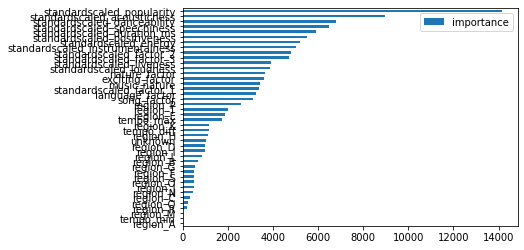

In [103]:
importance = model_lgb.feature_importance()
LightGBMimportance(importance,train_X)

In [10]:
features_data['nature_factor_mul'] = 1
features_data['exciting_factor_mul'] = 1
features_data['language_factor_mul'] = 1
features_data['song_factor_mul'] = 1

for col in [
    'standardscaled_acousticness','standardscaled_loudness','standardscaled_energy'
]:
    features_data['nature_factor_mul'] *= features_data[col]

for col in [
    'standardscaled_positiveness','standardscaled_danceability','standardscaled_instrumentalness'
]:
    features_data['exciting_factor_mul'] *= features_data[col]

for col in [
    'standardscaled_liveness','standardscaled_speechiness'
]:
    features_data['language_factor_mul'] *= features_data[col]
    
    
for col in [
    'standardscaled_loudness','standardscaled_instrumentalness'
]:
    features_data['song_factor_mul'] *= features_data[col]
    
features_data[['nature_factor_mul','exciting_factor_mul','language_factor_mul','song_factor_mul']].head()

,nature_factor_mul,exciting_factor_mul,language_factor_mul,song_factor_mul
0,-1.957327,11.830979,1.374217,6.204471
1,-0.704729,0.104207,0.214458,-0.309483
2,0.210517,-0.078260,-0.639576,0.122629
3,-0.612890,-0.231307,0.218308,-0.164118
4,-0.127167,0.199548,-0.164570,0.063976


In [11]:
features_data.to_csv(input / 'features_data.csv',index=False)

In [137]:
features_data[['nature_factor_mul','exciting_factor_mul','language_factor_mul','song_factor_mul']].describe()

,nature_factor_mul,exciting_factor_mul,language_factor_mul,song_factor_mul
count,8092.000000,8092.000000,8092.000000,8092.000000
mean,0.466013,0.146467,0.124434,-0.105546
std,2.767120,1.677712,1.176058,1.616862
min,-4.991829,-8.445152,-6.706419,-28.352233
25%,-0.286347,-0.228178,-0.154433,-0.224132
50%,-0.010948,-0.023243,0.040614,-0.018442
75%,0.157007,0.044266,0.309336,0.146733
max,45.202086,19.946439,28.188217,8.540432


In [187]:
features = [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   #'log_standardscaled_tempo',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor',
    'song_factor','log_tempo_max','log_tempo_diff',
]

data = features_data[features]
data.head()

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,factor_1,factor_2,factor_3,music_nature,nature_factor,exciting_factor,language_factor,song_factor,log_tempo_max,log_tempo_diff
0,0,0,0,0,0,0,0,1,0,0,...,-1.420504,2.259227,-0.021925,5.742936,1.907340,0.985881,2.849715,5.768700,5.023881,3.433987
1,0,0,0,0,0,0,0,0,1,0,...,-1.265113,0.284038,0.253307,-0.863710,0.857923,-0.795320,-0.926314,-0.062652,5.170484,3.135494
2,0,0,0,0,1,0,0,0,0,0,...,0.808452,0.326082,-0.240502,-0.393039,-0.566170,-1.492048,1.665179,-0.704443,4.330733,2.484907
3,0,0,1,0,0,0,0,0,0,0,...,-1.235781,1.103026,0.207864,0.068024,1.212081,-2.156487,1.012429,0.382009,5.257495,2.708050
4,0,0,0,0,0,0,0,0,0,0,...,-0.324308,-1.586230,-0.732366,3.675958,0.513928,3.527748,-0.365718,0.993303,4.787492,3.135494


In [188]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [189]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4477
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 39
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[196]	valid_0's multi_logloss: 1.02128
[197]	valid_0's multi_logloss: 1.0205
[198]	valid_0's multi_logloss: 1.02018
[199]	valid_0's multi_logloss: 1.01967
[200]	valid_0's multi_logloss: 1.01922
[201]	valid_0's multi_logloss: 1.01897
[202]	valid_0's multi_logloss: 1.0185
[203]	valid_0's multi_logloss: 1.01805
[204]	valid_0's multi_logloss: 1.01772
[205]	valid_0's multi_logloss: 1.01711
[206]	valid_0's multi_logloss: 1.01666
[207]	valid_0's multi_logloss: 1.01628
[208]	valid_0's multi_logloss: 1.01599
[209]	valid_0's multi_logloss: 1.01565
[210]	valid_0's multi_logloss: 1.01517
[211]	valid_0's multi_logloss: 1.01466
[212]	valid_0's multi_logloss: 1.01428
[213]	valid_0's multi_logloss: 1.01385
[214]	valid_0's multi_logloss: 1.01334
[215]	valid_0's multi_logloss: 1.0129
[216]	valid_0's multi_logloss: 1.01255
[217]	valid_0's multi_logloss: 1.01231
[218]	valid_0's multi_logloss: 1.01188
[219]	valid_0's multi_logloss: 1.01159
[220]	valid_0's multi_logloss: 1.01117
[221]	valid_0's multi_loglos

[414]	valid_0's multi_logloss: 0.989194
[415]	valid_0's multi_logloss: 0.989426
[416]	valid_0's multi_logloss: 0.989543
[417]	valid_0's multi_logloss: 0.989518
[418]	valid_0's multi_logloss: 0.989564
[419]	valid_0's multi_logloss: 0.989699
[420]	valid_0's multi_logloss: 0.989929
[421]	valid_0's multi_logloss: 0.990218
[422]	valid_0's multi_logloss: 0.990509
[423]	valid_0's multi_logloss: 0.990692
[424]	valid_0's multi_logloss: 0.990932
[425]	valid_0's multi_logloss: 0.990923
[426]	valid_0's multi_logloss: 0.991051
[427]	valid_0's multi_logloss: 0.991232
[428]	valid_0's multi_logloss: 0.991336
[429]	valid_0's multi_logloss: 0.991525
[430]	valid_0's multi_logloss: 0.991625
[431]	valid_0's multi_logloss: 0.991935
[432]	valid_0's multi_logloss: 0.991912
[433]	valid_0's multi_logloss: 0.992239
[434]	valid_0's multi_logloss: 0.992337
[435]	valid_0's multi_logloss: 0.992484
[436]	valid_0's multi_logloss: 0.992547
[437]	valid_0's multi_logloss: 0.992696
[438]	valid_0's multi_logloss: 0.992565


In [170]:
for col in ['nature_factor_mul','exciting_factor_mul','language_factor_mul','song_factor_mul','music_nature_mul']:
    features_data['abs_' + col] = abs(features_data[col])

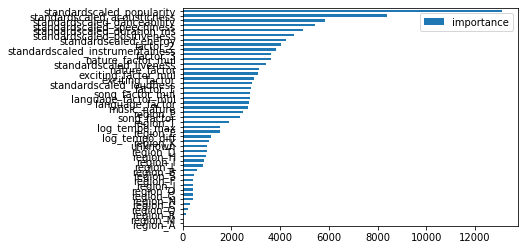

In [154]:
importance = model_lgb.feature_importance()
LightGBMimportance(importance,train_X)

In [168]:
for col in ['nature_factor','exciting_factor','language_factor','song_factor','music_nature']:
    features_data['abs_' + col] = abs(features_data[col])

In [9]:
features_data['music_nature_mul'] = 1
for col in [
    'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    features_data['music_nature_mul'] *= features_data[col]

In [172]:
for col in ['abs_nature_factor','abs_exciting_factor','abs_language_factor',
            'abs_song_factor','abs_nature_factor_mul','abs_exciting_factor_mul','abs_language_factor_mul',
            'abs_song_factor_mul','abs_music_nature','abs_music_nature_mul']:
    features_data['log_' + col] = np.log(features_data[col])

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [197]:
agg_region_feature = pd.read_csv(input / 'agg_region_feature.csv')
agg_region_feature.head()

,agg_min_popularity_grpby_region,agg_min_duration_ms_grpby_region,agg_min_acousticness_grpby_region,agg_min_positiveness_grpby_region,agg_min_danceability_grpby_region,agg_min_loudness_grpby_region,agg_min_energy_grpby_region,agg_min_liveness_grpby_region,agg_min_speechiness_grpby_region,agg_min_instrumentalness_grpby_region,...,agg_z-score_duration_ms_grpby_region,agg_z-score_energy_grpby_region,agg_z-score_instrumentalness_grpby_region,agg_z-score_liveness_grpby_region,agg_z-score_loudness_grpby_region,agg_z-score_max_tempo_grpby_region,agg_z-score_min_tempo_grpby_region,agg_z-score_popularity_grpby_region,agg_z-score_positiveness_grpby_region,agg_z-score_speechiness_grpby_region
0,0,55429,0.038197,0.022442,0.030016,-23.232876,0.000000,0.036888,0.016510,0.066214,...,-3.217501,-1.927687,-0.266825,-12.779563,2.164936,-4.421751,-3.985571,-1.972806,539.281360,1802.860929
1,0,6188,0.000000,0.000966,0.006902,-31.585695,0.020259,0.027710,0.025280,0.042803,...,-3.160061,-1.431521,2.733213,-36.379671,2.163298,-4.325739,-3.800545,-2.473178,706.218487,1961.478299
2,3,12105,0.012727,0.007439,0.013839,-34.237218,0.037083,0.030346,0.022649,0.032990,...,-3.766667,-1.705845,1.979501,-62.826406,2.111004,-4.508999,-3.958832,-2.842025,292.552647,878.806967
3,6,37293,0.035622,0.026519,0.073056,-27.250187,0.059452,0.076070,0.052196,0.090735,...,-2.727106,-2.364495,1.019218,-40.382451,2.057631,-4.567477,-3.876738,-2.533992,803.535518,2467.528678
4,0,6506,0.035769,0.000000,0.041755,-31.505017,0.066102,0.046441,0.034162,0.036902,...,-2.626776,0.827241,4.067399,-26.295846,2.096662,-4.535397,-3.956118,-2.475282,435.957115,1371.328978


In [152]:
train_y = df['genre'][:train_len]
train_X = agg_region_feature[:train_len]
test_X = agg_region_feature[train_len:]

NameError: name 'agg_region_feature' is not defined

In [153]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4491
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 101
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[186]	valid_0's multi_logloss: 0.958458
[187]	valid_0's multi_logloss: 0.957306
[188]	valid_0's multi_logloss: 0.956409
[189]	valid_0's multi_logloss: 0.955734
[190]	valid_0's multi_logloss: 0.954849
[191]	valid_0's multi_logloss: 0.954437
[192]	valid_0's multi_logloss: 0.953779
[193]	valid_0's multi_logloss: 0.952929
[194]	valid_0's multi_logloss: 0.952322
[195]	valid_0's multi_logloss: 0.951778
[196]	valid_0's multi_logloss: 0.95119
[197]	valid_0's multi_logloss: 0.950717
[198]	valid_0's multi_logloss: 0.94997
[199]	valid_0's multi_logloss: 0.949152
[200]	valid_0's multi_logloss: 0.948513
[201]	valid_0's multi_logloss: 0.947911
[202]	valid_0's multi_logloss: 0.946963
[203]	valid_0's multi_logloss: 0.946546
[204]	valid_0's multi_logloss: 0.94586
[205]	valid_0's multi_logloss: 0.945345
[206]	valid_0's multi_logloss: 0.94453
[207]	valid_0's multi_logloss: 0.944251
[208]	valid_0's multi_logloss: 0.94323
[209]	valid_0's multi_logloss: 0.942672
[210]	valid_0's multi_logloss: 0.941995
[211]

[393]	valid_0's multi_logloss: 0.911697
[394]	valid_0's multi_logloss: 0.911518
[395]	valid_0's multi_logloss: 0.911423
[396]	valid_0's multi_logloss: 0.911551
[397]	valid_0's multi_logloss: 0.911499
[398]	valid_0's multi_logloss: 0.911669
[399]	valid_0's multi_logloss: 0.91177
[400]	valid_0's multi_logloss: 0.911727
[401]	valid_0's multi_logloss: 0.911646
[402]	valid_0's multi_logloss: 0.911599
[403]	valid_0's multi_logloss: 0.911793
[404]	valid_0's multi_logloss: 0.911802
[405]	valid_0's multi_logloss: 0.911723
[406]	valid_0's multi_logloss: 0.911898
[407]	valid_0's multi_logloss: 0.911899
[408]	valid_0's multi_logloss: 0.911913
[409]	valid_0's multi_logloss: 0.912058
[410]	valid_0's multi_logloss: 0.9121
[411]	valid_0's multi_logloss: 0.912146
[412]	valid_0's multi_logloss: 0.912472
[413]	valid_0's multi_logloss: 0.912409
[414]	valid_0's multi_logloss: 0.912527
[415]	valid_0's multi_logloss: 0.912487
[416]	valid_0's multi_logloss: 0.912537
[417]	valid_0's multi_logloss: 0.912679
[41

In [193]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,10
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [200]:
features = [
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
    'factor_1','factor_2','factor_3','music_nature',
    'nature_factor','exciting_factor','language_factor',
    'song_factor','log_tempo_max','log_tempo_diff',
    'music_nature_mul',
    'nature_factor_mul','exciting_factor_mul','language_factor_mul',
    'song_factor_mul',
]

data = features_data[features]
data.head()

,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,...,exciting_factor,language_factor,song_factor,log_tempo_max,log_tempo_diff,music_nature_mul,nature_factor_mul,exciting_factor_mul,language_factor_mul,song_factor_mul
0,-1.866000,-0.499932,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,...,0.985881,2.849715,5.768700,5.023881,3.433987,-31.822863,-1.957327,11.830979,1.374217,6.204471
1,1.728761,0.812810,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,...,-0.795320,-0.926314,-0.062652,5.170484,3.135494,-0.015749,-0.704729,0.104207,0.214458,-0.309483
2,0.117317,-0.547223,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,...,-1.492048,1.665179,-0.704443,4.330733,2.484907,0.010537,0.210517,-0.078260,-0.639576,0.122629
3,0.241274,0.722347,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,...,-2.156487,1.012429,0.382009,5.257495,2.708050,0.030949,-0.612890,-0.231307,0.218308,-0.164118
4,0.985018,0.432123,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,...,3.527748,-0.365718,0.993303,4.787492,3.135494,0.004176,-0.127167,0.199548,-0.164570,0.063976


In [18]:
train_y = df['genre'][:train_len]
train_X = data[:train_len]
test_X = data[train_len:]

In [22]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 13
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positiv

[186]	valid_0's multi_logloss: 1.29162
[187]	valid_0's multi_logloss: 1.29127
[188]	valid_0's multi_logloss: 1.29107
[189]	valid_0's multi_logloss: 1.29082
[190]	valid_0's multi_logloss: 1.29054
[191]	valid_0's multi_logloss: 1.29046
[192]	valid_0's multi_logloss: 1.29005
[193]	valid_0's multi_logloss: 1.29004
[194]	valid_0's multi_logloss: 1.28979
[195]	valid_0's multi_logloss: 1.28931
[196]	valid_0's multi_logloss: 1.28925
[197]	valid_0's multi_logloss: 1.28907
[198]	valid_0's multi_logloss: 1.28879
[199]	valid_0's multi_logloss: 1.28864
[200]	valid_0's multi_logloss: 1.28814
[201]	valid_0's multi_logloss: 1.28789
[202]	valid_0's multi_logloss: 1.28776
[203]	valid_0's multi_logloss: 1.2875
[204]	valid_0's multi_logloss: 1.28725
[205]	valid_0's multi_logloss: 1.28719
[206]	valid_0's multi_logloss: 1.2869
[207]	valid_0's multi_logloss: 1.28678
[208]	valid_0's multi_logloss: 1.28677
[209]	valid_0's multi_logloss: 1.28649
[210]	valid_0's multi_logloss: 1.28611
[211]	valid_0's multi_loglo

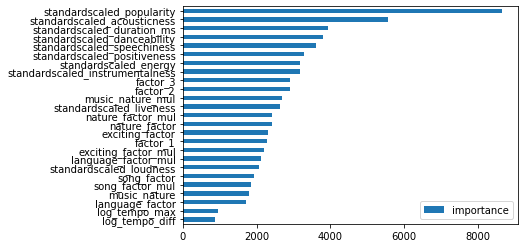

In [203]:
importance = model_lgb.feature_importance()
LightGBMimportance(importance,train_X)

In [60]:
features = [
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
    'factor_1','factor_2','factor_3',
    'music_nature_mul','nature_factor','exciting_factor',
    'language_factor_mul'
]

data = features_data[features]
data.head()

,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,factor_1,factor_2,factor_3,music_nature_mul,nature_factor,exciting_factor,language_factor_mul
0,-1.866000,-0.499932,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,-1.420504,2.259227,-0.021925,-31.822863,1.907340,0.985881,1.374217
1,1.728761,0.812810,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,-1.265113,0.284038,0.253307,-0.015749,0.857923,-0.795320,0.214458
2,0.117317,-0.547223,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,0.808452,0.326082,-0.240502,0.010537,-0.566170,-1.492048,-0.639576
3,0.241274,0.722347,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,-1.235781,1.103026,0.207864,0.030949,1.212081,-2.156487,0.218308
4,0.985018,0.432123,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,-0.324308,-1.586230,-0.732366,0.004176,0.513928,3.527748,-0.164570


In [61]:
concat_data = pd.concat([data,region_feature],axis=1)

In [41]:
train_y = df['genre'][:train_len]
train_X = concat_data[:train_len]
test_X = concat_data[train_len:]

In [42]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7634
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 114
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from score -2.429604
[LightGBM] [Info] Start training from score -4.526745
[LightGBM] [Info] Start training from score -3.538798
[LightGBM] [Info] Start training from score -4.297904
[LightGBM] [Info] Start training from score -2.479974
[LightGBM] [Info] Start training from score -1.138971
[LightGBM] [Info] Start training from score -4.210892
[LightGBM] [Info] Start training from score -1.104812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[181]	valid_0's multi_logloss: 0.932451
[182]	valid_0's multi_logloss: 0.931695
[183]	valid_0's multi_logloss: 0.930896
[184]	valid_0's multi_logloss: 0.930306
[185]	valid_0's multi_logloss: 0.929661
[186]	valid_0's multi_logloss: 0.928818
[187]	valid_0's multi_logloss: 0.927956
[188]	valid_0's multi_logloss: 0.927277
[189]	valid_0's multi_logloss: 0.926916
[190]	valid_0's multi_logloss: 0.926414
[191]	valid_0's multi_logloss: 0.925844
[192]	valid_0's multi_logloss: 0.925268
[193]	valid_0's multi_logloss: 0.924858
[194]	valid_0's multi_logloss: 0.924121
[195]	valid_0's multi_logloss: 0.923205
[196]	valid_0's multi_logloss: 0.922974
[197]	valid_0's multi_logloss: 0.922422
[198]	valid_0's multi_logloss: 0.921773
[199]	valid_0's multi_logloss: 0.921212
[200]	valid_0's multi_logloss: 0.920702
[201]	valid_0's multi_logloss: 0.920255
[202]	valid_0's multi_logloss: 0.919698
[203]	valid_0's multi_logloss: 0.919095
[204]	valid_0's multi_logloss: 0.918591
[205]	valid_0's multi_logloss: 0.917766


[390]	valid_0's multi_logloss: 0.879837
[391]	valid_0's multi_logloss: 0.879614
[392]	valid_0's multi_logloss: 0.87953
[393]	valid_0's multi_logloss: 0.879241
[394]	valid_0's multi_logloss: 0.879267
[395]	valid_0's multi_logloss: 0.879176
[396]	valid_0's multi_logloss: 0.879048
[397]	valid_0's multi_logloss: 0.879124
[398]	valid_0's multi_logloss: 0.87928
[399]	valid_0's multi_logloss: 0.879168
[400]	valid_0's multi_logloss: 0.879383
[401]	valid_0's multi_logloss: 0.879433
[402]	valid_0's multi_logloss: 0.879619
[403]	valid_0's multi_logloss: 0.879766
[404]	valid_0's multi_logloss: 0.880131
[405]	valid_0's multi_logloss: 0.880109
[406]	valid_0's multi_logloss: 0.880226
[407]	valid_0's multi_logloss: 0.880199
[408]	valid_0's multi_logloss: 0.880245
[409]	valid_0's multi_logloss: 0.880306
[410]	valid_0's multi_logloss: 0.880303
[411]	valid_0's multi_logloss: 0.880233
[412]	valid_0's multi_logloss: 0.880633
[413]	valid_0's multi_logloss: 0.880601
[414]	valid_0's multi_logloss: 0.880659
[4

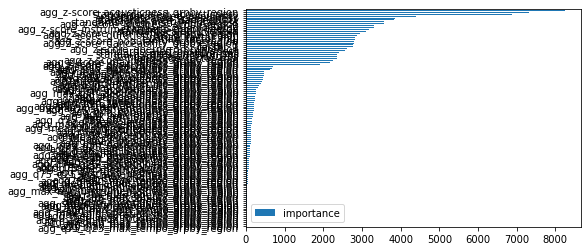

In [208]:
importance = model_lgb.feature_importance()
LightGBMimportance(importance,train_X)

In [311]:
LightGBMSubmission.head(20)

,index,genre
0,4046,7
1,4047,10
2,4048,8
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [312]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission8.csv", header=None, index=False)

In [19]:
dropcols = [
    'agg_z-score_popularity_grpby_region','agg_z-score_min_tempo_grpby_region','agg_z-score_duration_ms_grpby_region',
    'agg_z-score_max_tempo_grpby_region','agg_z-score_loudness_grpby_region','agg_z-score_instrumentalness_grpby_region',
    'agg_z-score_energy_grpby_region'
]

dropdata = concat_data.drop(dropcols,axis=1)

In [260]:
agg_region_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 96 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   agg_min_popularity_grpby_region            8092 non-null   int64  
 1   agg_min_duration_ms_grpby_region           8092 non-null   int64  
 2   agg_min_acousticness_grpby_region          8092 non-null   float64
 3   agg_min_positiveness_grpby_region          8092 non-null   float64
 4   agg_min_danceability_grpby_region          8092 non-null   float64
 5   agg_min_loudness_grpby_region              8092 non-null   float64
 6   agg_min_energy_grpby_region                8092 non-null   float64
 7   agg_min_liveness_grpby_region              8092 non-null   float64
 8   agg_min_speechiness_grpby_region           8092 non-null   float64
 9   agg_min_instrumentalness_grpby_region      8092 non-null   float64
 10  agg_min_min_tempo_grpby_

In [279]:
train_y = df['genre'][:train_len]
train_X = dropdata[:train_len]
test_X = dropdata[train_len:]

LogisticModel(train_X,train_y)

正解率(train): 0.465
正解率(test): 0.460
正解率(F1): 0.193


C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [34]:
region_feature = pd.read_csv(input / 'agg_region_feature.csv')
region_feature.head()

,agg_min_popularity_grpby_region,agg_min_duration_ms_grpby_region,agg_min_acousticness_grpby_region,agg_min_positiveness_grpby_region,agg_min_danceability_grpby_region,agg_min_loudness_grpby_region,agg_min_energy_grpby_region,agg_min_liveness_grpby_region,agg_min_speechiness_grpby_region,agg_min_instrumentalness_grpby_region,...,agg_z-score_duration_ms_grpby_region,agg_z-score_energy_grpby_region,agg_z-score_instrumentalness_grpby_region,agg_z-score_liveness_grpby_region,agg_z-score_loudness_grpby_region,agg_z-score_max_tempo_grpby_region,agg_z-score_min_tempo_grpby_region,agg_z-score_popularity_grpby_region,agg_z-score_positiveness_grpby_region,agg_z-score_speechiness_grpby_region
0,0,55429,0.038197,0.022442,0.030016,-23.232876,0.000000,0.036888,0.016510,0.066214,...,-3.217501,-1.927687,-0.266825,-12.779563,2.164936,-4.421751,-3.985571,-1.972806,539.281360,1802.860929
1,0,6188,0.000000,0.000966,0.006902,-31.585695,0.020259,0.027710,0.025280,0.042803,...,-3.160061,-1.431521,2.733213,-36.379671,2.163298,-4.325739,-3.800545,-2.473178,706.218487,1961.478299
2,3,12105,0.012727,0.007439,0.013839,-34.237218,0.037083,0.030346,0.022649,0.032990,...,-3.766667,-1.705845,1.979501,-62.826406,2.111004,-4.508999,-3.958832,-2.842025,292.552647,878.806967
3,6,37293,0.035622,0.026519,0.073056,-27.250187,0.059452,0.076070,0.052196,0.090735,...,-2.727106,-2.364495,1.019218,-40.382451,2.057631,-4.567477,-3.876738,-2.533992,803.535518,2467.528678
4,0,6506,0.035769,0.000000,0.041755,-31.505017,0.066102,0.046441,0.034162,0.036902,...,-2.626776,0.827241,4.067399,-26.295846,2.096662,-4.535397,-3.956118,-2.475282,435.957115,1371.328978


In [120]:
features_data = pd.read_csv(input / 'features_data.csv')

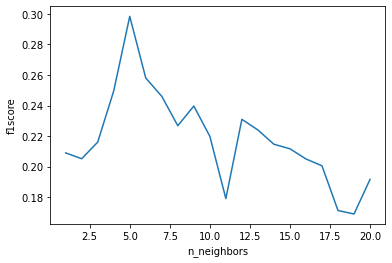

In [22]:
train_y = df['genre'][:train_len]
train_X = dropdata[:train_len]
test_X = dropdata[train_len:]

KnnModel(train_X,train_y)

In [26]:
region_feature_new = pd.read_csv(input / 'agg_region_feature_new.csv')
region_feature_new.head()

,agg_min_popularity_grpby_region,agg_min_duration_ms_grpby_region,agg_min_acousticness_grpby_region,agg_min_positiveness_grpby_region,agg_min_danceability_grpby_region,agg_min_loudness_grpby_region,agg_min_energy_grpby_region,agg_min_liveness_grpby_region,agg_min_speechiness_grpby_region,agg_min_instrumentalness_grpby_region,...,agg_z-score_language_factor_mul_grpby_region,agg_z-score_liveness_grpby_region,agg_z-score_loudness_grpby_region,agg_z-score_max_tempo_grpby_region,agg_z-score_min_tempo_grpby_region,agg_z-score_music_nature_mul_grpby_region,agg_z-score_nature_factor_grpby_region,agg_z-score_popularity_grpby_region,agg_z-score_positiveness_grpby_region,agg_z-score_speechiness_grpby_region
0,0,55429,0.038197,0.022442,0.030016,-23.232876,0.000000,0.036888,0.016510,0.066214,...,0.757698,714.926993,37.649746,-4.480734,-3.917317,-0.048396,-20.174544,-1.911373,2.542370,13.955430
1,0,6188,0.000000,0.000966,0.006902,-31.585695,0.020259,0.027710,0.025280,0.042803,...,-0.026756,954.692910,48.027004,-4.372777,-3.796312,0.010522,-0.051910,-2.428227,-5.933799,0.096183
2,3,12105,0.012727,0.007439,0.013839,-34.237218,0.037083,0.030346,0.022649,0.032990,...,0.016672,420.808145,22.368116,-4.488915,-3.960402,-0.073105,-0.023531,-2.889539,-8.928100,-9.735932
3,6,37293,0.035622,0.026519,0.073056,-27.250187,0.059452,0.076070,0.052196,0.090735,...,0.272906,1332.477176,58.061077,-4.619677,-3.847656,0.441216,-0.241678,-2.467952,-11.571991,0.323010
4,0,6506,0.035769,0.000000,0.041755,-31.505017,0.066102,0.046441,0.034162,0.036902,...,0.085373,605.458816,31.874023,-4.551939,-4.020778,-0.191063,-0.008116,-2.457810,13.857491,-4.226354


In [31]:
concat_data = pd.concat([data,region_feature_new],axis=1)

In [113]:
features = [
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
    'factor_1','factor_2','factor_3',
    'music_nature_mul','nature_factor','exciting_factor',
    'language_factor_mul'
]

data = features_data[features]
data.head()

,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,factor_1,factor_2,factor_3,music_nature_mul,nature_factor,exciting_factor,language_factor_mul
0,-1.866000,-0.499932,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,-1.420504,2.259227,-0.021925,-31.822863,1.907340,0.985881,1.374217
1,1.728761,0.812810,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,-1.265113,0.284038,0.253307,-0.015749,0.857923,-0.795320,0.214458
2,0.117317,-0.547223,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,0.808452,0.326082,-0.240502,0.010537,-0.566170,-1.492048,-0.639576
3,0.241274,0.722347,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,-1.235781,1.103026,0.207864,0.030949,1.212081,-2.156487,0.218308
4,0.985018,0.432123,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,-0.324308,-1.586230,-0.732366,0.004176,0.513928,3.527748,-0.164570


In [34]:
region_feature_standardscaled = pd.read_csv(input / 'agg_region_feature_standardscaled.csv')

In [35]:
concat_data = pd.concat([data,region_feature],axis=1)

In [39]:
region_feature_standardscaled.head()

,Unnamed: 0,agg_min_standardscaled_popularity_grpby_region,agg_min_standardscaled_duration_ms_grpby_region,agg_min_standardscaled_acousticness_grpby_region,agg_min_standardscaled_positiveness_grpby_region,agg_min_standardscaled_danceability_grpby_region,agg_min_standardscaled_loudness_grpby_region,agg_min_standardscaled_energy_grpby_region,agg_min_standardscaled_liveness_grpby_region,agg_min_standardscaled_speechiness_grpby_region,...,agg_z-score_standardscaled_acousticness_grpby_region,agg_z-score_standardscaled_danceability_grpby_region,agg_z-score_standardscaled_duration_ms_grpby_region,agg_z-score_standardscaled_energy_grpby_region,agg_z-score_standardscaled_instrumentalness_grpby_region,agg_z-score_standardscaled_liveness_grpby_region,agg_z-score_standardscaled_loudness_grpby_region,agg_z-score_standardscaled_popularity_grpby_region,agg_z-score_standardscaled_positiveness_grpby_region,agg_z-score_standardscaled_speechiness_grpby_region
0,0,-2.547765,-2.280400,-1.267979,-1.993492,-2.953220,-3.841472,-3.018640,-1.475137,-2.161968,...,-1.900666,-0.245508,-1.031045,-1.172841,-1.874793,1.296218,1.513791,1.050639,2.449446,4.439042
1,1,-2.547765,-2.882274,-1.428016,-2.090020,-3.097927,-5.904053,-2.917758,-1.533854,-2.058755,...,1.912390,0.777754,-1.046576,-0.642764,0.518494,0.479774,1.339345,-0.428024,-0.564944,-0.627273
2,2,-2.361829,-2.809951,-1.374692,-2.060928,-3.054499,-6.558799,-2.833985,-1.516991,-2.089717,...,0.089237,-0.649026,0.721742,-0.884538,-0.206426,-0.359149,-0.962987,-0.523179,2.128777,-0.312726
3,3,-2.175893,-2.502077,-1.278767,-1.975168,-2.683776,-4.833476,-2.722595,-1.224454,-1.741988,...,0.779672,1.084773,-0.802441,-1.501076,-1.030276,0.758697,1.103945,0.793265,0.677054,-0.192823
4,4,-2.547765,-2.878387,-1.278154,-2.094361,-2.879730,-5.884131,-2.689482,-1.414019,-1.954226,...,0.966477,0.462561,-0.582564,1.377961,2.132495,0.910284,0.240188,-0.608424,0.295787,0.017038


In [49]:
region_feature_standard_scaled = region_feature_standardscaled.drop('Unnamed: 0',axis=1)

In [50]:
concat_data = pd.concat([concat_data,region_feature_standard_scaled],axis=1)

In [189]:
concat_data = pd.concat([data,region_feature_addtempo],axis=1)

In [109]:
region_feature_addtempo = pd.read_csv(input / 'agg_region_feature_addtempo.csv')

In [117]:
region_dummy = pd.read_csv(input / 'region_dummy.csv')

In [366]:
concat_data = pd.concat([concat_data,groupdata],axis=1)

In [121]:
groupdata = pd.read_csv(input / 'groupdata.csv')

In [11]:
get_ce_features = pd.read_csv(input / 'get_ce_features.csv')
get_oe_features = pd.read_csv(input / 'get_oe_features.csv')
get_binned_popularity_features = pd.read_csv(input / 'get_binned_popularity_features.csv')

In [36]:
concat_data = pd.concat([concat_data,get_ce_features],axis=1)

In [37]:
concat_data = pd.concat([concat_data,get_oe_features],axis=1)

In [38]:
concat_data = pd.concat([concat_data,get_binned_popularity_features],axis=1)

In [200]:
concat_data = pd.concat([region_feature,region_dummy],axis=1)

In [154]:
features = [
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'factor_1',
    'factor_2','factor_3',
    #'music_nature_mul',
    #'nature_factor','exciting_factor',
    #'language_factor_mul'
]

data = features_data[features]
data.head()

,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,factor_1,factor_2,factor_3
0,-1.866000,-0.499932,-0.955367,-1.387603,-1.965171,1.430045,1.432662,0.614918,2.234797,4.338655,-1.420504,2.259227,-0.021925
1,1.728761,0.812810,-1.003456,-0.536710,0.329910,0.525867,1.335512,-0.470650,-0.455665,-0.588519,-1.265113,0.284038,0.253307
2,0.117317,-0.547223,0.651855,-0.901545,-0.276109,-0.390048,-0.827977,-0.321872,1.987051,-0.314395,0.808452,0.326082,-0.240502
3,0.241274,0.722347,-0.733915,-0.990798,-0.908808,0.638890,1.307106,0.701010,0.311420,-0.256881,-1.235781,1.103026,0.207864
4,0.985018,0.432123,-0.628947,1.400512,2.058003,0.924070,0.218805,-0.627839,0.262121,0.069233,-0.324308,-1.586230,-0.732366


In [384]:
concat_data = pd.concat([data,region_feature_notempo],axis=1)

In [4]:
region_feature_notempo = pd.read_csv(input / 'agg_region_feature_addtempo.csv')

In [5]:
get_tempo_features = pd.read_csv(input / 'get_tempo_features.csv')

In [26]:
concat_data = pd.concat([data,get_tempo_features],axis=1)

In [155]:
agg_features = pd.read_csv(input / 'agg_region_feature.csv')
concat_data = pd.concat([data,agg_features],axis=1)
concat_data = pd.concat([concat_data,get_ce_features],axis=1)
concat_data = pd.concat([concat_data,get_oe_features],axis=1)
concat_data = pd.concat([concat_data,get_binned_popularity_features],axis=1)

In [156]:
train_y = df['genre'][:train_len]
train_X = concat_data[:train_len]
test_X = concat_data[train_len:]

In [249]:
model_lgb = LightGBM(train_X,train_y)

sample_sub = pd.read_csv(input / 'sample_submit.csv', header=None)
sample_sub.columns = ['index', 'genre']

pred_y = model_lgb.predict(test_X,num_iteration=model_lgb.best_iteration)
test['prediction'] = np.argmax(pred_y, axis=1)
submission_df = sample_sub.copy()
submission_df["genre"] = submission_df["index"].map(dict(test[["index", "prediction"]].values))
assert not submission_df["genre"].isna().any()

LightGBMSubmission = submission_df

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.1, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.1, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9306
[LightGBM] [Info] Number of data points in the train set: 3236, number of used features: 114
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.1, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Info] Start training from score -4.749889
[LightGBM] [Info] Start training from score -2.964099
[LightGBM] [Info] Start training from score -3.032237
[LightGBM] [Info] Start training from scor

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's multi_logloss: 1.60341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's multi_logloss: 1.48754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's multi_logloss: 1.40288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's multi_logloss: 1.33923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's multi_logloss: 1.28921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's multi_logloss: 1.25061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's multi_logloss: 1.24716
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's multi_logloss: 1.21566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's multi_logloss: 1.1876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[104]	valid_0's multi_logloss: 1.16523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's multi_logloss: 1.16325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's multi_logloss: 1.14241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's multi_logloss: 1.1412
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's multi_logloss: 1.12586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's multi_logloss: 1.11212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's multi_logloss: 1.09977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's multi_logloss: 1.08815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's multi_logloss: 1.0872
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's multi_logloss: 1.07501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's multi_logloss: 1.06397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's multi_logloss: 1.05577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's multi_logloss: 1.04747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's multi_logloss: 1.03978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's multi_logloss: 1.03933
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's multi_logloss: 1.03316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's multi_logloss: 1.0259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's multi_logloss: 1.01921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's multi_logloss: 1.01238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's multi_logloss: 1.00687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's multi_logloss: 1.00141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's multi_logloss: 0.995448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[316]	valid_0's multi_logloss: 0.990191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's multi_logloss: 0.985786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's multi_logloss: 0.98172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's multi_logloss: 0.977466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[362]	valid_0's multi_logloss: 0.9733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's multi_logloss: 0.970199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's multi_logloss: 0.965971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	valid_0's multi_logloss: 0.962757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's multi_logloss: 0.959504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's multi_logloss: 0.956288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's multi_logloss: 0.956199
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's multi_logloss: 0.953454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's multi_logloss: 0.95107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's multi_logloss: 0.948261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's multi_logloss: 0.94801
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[464]	valid_0's multi_logloss: 0.944896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[465]	valid_0's multi_logloss: 0.944841
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's multi_logloss: 0.942841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's multi_logloss: 0.942615
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's multi_logloss: 0.940197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's multi_logloss: 0.937846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's multi_logloss: 0.935631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's multi_logloss: 0.933499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's multi_logloss: 0.931693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's multi_logloss: 0.929881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[558]	valid_0's multi_logloss: 0.927603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's multi_logloss: 0.92578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	valid_0's multi_logloss: 0.923715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's multi_logloss: 0.922199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's multi_logloss: 0.920398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's multi_logloss: 0.918818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[627]	valid_0's multi_logloss: 0.916736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[638]	valid_0's multi_logloss: 0.914939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[650]	valid_0's multi_logloss: 0.912905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's multi_logloss: 0.911677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's multi_logloss: 0.910185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's multi_logloss: 0.910174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's multi_logloss: 0.908867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[695]	valid_0's multi_logloss: 0.907754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[706]	valid_0's multi_logloss: 0.907122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[707]	valid_0's multi_logloss: 0.907008
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[718]	valid_0's multi_logloss: 0.907068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's multi_logloss: 0.906661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's multi_logloss: 0.905878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's multi_logloss: 0.905632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[763]	valid_0's multi_logloss: 0.905424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	valid_0's multi_logloss: 0.904597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's multi_logloss: 0.903915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[786]	valid_0's multi_logloss: 0.903844
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[796]	valid_0's multi_logloss: 0.903635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's multi_logloss: 0.902884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's multi_logloss: 0.901851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's multi_logloss: 0.901156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[840]	valid_0's multi_logloss: 0.900309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	valid_0's multi_logloss: 0.899856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[861]	valid_0's multi_logloss: 0.899383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[862]	valid_0's multi_logloss: 0.899414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's multi_logloss: 0.898622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's multi_logloss: 0.898028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's multi_logloss: 0.898078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[906]	valid_0's multi_logloss: 0.897424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[917]	valid_0's multi_logloss: 0.89728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's multi_logloss: 0.896873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[938]	valid_0's multi_logloss: 0.896384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[949]	valid_0's multi_logloss: 0.895765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's multi_logloss: 0.895028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's multi_logloss: 0.894627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's multi_logloss: 0.894689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's multi_logloss: 0.89452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1002]	valid_0's multi_logloss: 0.894211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's multi_logloss: 0.893809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1024]	valid_0's multi_logloss: 0.893632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's multi_logloss: 0.893201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1045]	valid_0's multi_logloss: 0.892942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1056]	valid_0's multi_logloss: 0.892501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1067]	valid_0's multi_logloss: 0.892058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's multi_logloss: 0.891841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's multi_logloss: 0.891499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1088]	valid_0's multi_logloss: 0.891602
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1099]	valid_0's multi_logloss: 0.891695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1110]	valid_0's multi_logloss: 0.891196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1120]	valid_0's multi_logloss: 0.891178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's multi_logloss: 0.891091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	valid_0's multi_logloss: 0.890881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's multi_logloss: 0.890457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1161]	valid_0's multi_logloss: 0.889941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1171]	valid_0's multi_logloss: 0.889698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1182]	valid_0's multi_logloss: 0.889796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's multi_logloss: 0.890049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's multi_logloss: 0.890033
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1203]	valid_0's multi_logloss: 0.890048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1222]	valid_0's multi_logloss: 0.890172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1232]	valid_0's multi_logloss: 0.890129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1242]	valid_0's multi_logloss: 0.890378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1253]	valid_0's multi_logloss: 0.890604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's multi_logloss: 0.890673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [121]:
features = [
    'factor_1','factor_2','factor_3',
    'music_nature_mul','nature_factor','exciting_factor',
    'language_factor_mul'
]

data = features_data[features]
data.head()

,factor_1,factor_2,factor_3,music_nature_mul,nature_factor,exciting_factor,language_factor_mul
0,-1.420504,2.259227,-0.021925,-31.822863,1.907340,0.985881,1.374217
1,-1.265113,0.284038,0.253307,-0.015749,0.857923,-0.795320,0.214458
2,0.808452,0.326082,-0.240502,0.010537,-0.566170,-1.492048,-0.639576
3,-1.235781,1.103026,0.207864,0.030949,1.212081,-2.156487,0.218308
4,-0.324308,-1.586230,-0.732366,0.004176,0.513928,3.527748,-0.164570


In [122]:
data.to_csv(input / 'factor_features_data.csv',index=False)

In [248]:
import lightgbm as lgb

def LightGBM(train_X,train_y):
    
    
    X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2021)
    
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)
    
    lgbm_params = {
        'task':'train',
        'objective': 'multiclass', # 目的 : 多クラス分類 
        'num_class': 11, # クラス数 : 11
        "learning_rate": 0.01,
        'reg_alpha':0.1,
        'reg_lambda':0.1,
        'num_leaves':33,
        'max_bin':331,
        'min_data_in_leaf':57,
        'gamma':0.0,
        'lambda':1.0,
        "n_estimators": 10000,
        'random_state':2021
}
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         early_stopping_rounds=100)

    
    return model_lgb

In [233]:
LightGBMSubmission.head(20)

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [234]:
output = Path('output')
LightGBMSubmission.to_csv(output / "LightGBMSubmission10.csv", header=None, index=False)